# Trabalho de Aprendizado de Máquina - Prof. Diego

## Guilherme Vilar Balduino
## Max Marcio Fonseca Santos
## Roberto Akio Oizuni Yamamoto

#Imports


In [ ]:
!pip install kneed

In [ ]:
import pandas as pd
import numpy as np

#Grafico
import matplotlib.pyplot as plt
import seaborn as sns

# Agrupamento hierárquico
import scipy.cluster.hierarchy as sch
from sklearn.cluster import AgglomerativeClustering

# K-means
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
from sklearn.metrics import silhouette_score, adjusted_rand_score
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import LabelEncoder, MinMaxScaler, StandardScaler
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
from kneed import KneeLocator

#DBSCAN
from sklearn.cluster import DBSCAN
from sklearn.decomposition import PCA

# Explicação do dataset e pré processamento

O dataset representa o número de reviews que cada pessoa de um certo grupo fez sobre diferentes categorias de passeio, sendo eles:
* Estádios esportivos
* Instituições religiosas
* Praias e lagos
* Teatros
* Shoppings
* Parques

Além desses atributos, há um atributo chamado User ID que representa a ID do reviewer. Como essa informação é irrelevante para o agrupamento, ele será removido do dataset antes da aplicação dos algoritmos.

Para o pré processamento, será feita o escalonamento MinMax dos dados, para melhorar os resultados dos algoritmos de agrupamento.

Link do dataset: [Dataset](https://archive.ics.uci.edu/ml/datasets/BuddyMove+Data+Set)

In [ ]:
dados = pd.read_csv("https://github.com/Vilardino/AM1-2/blob/main/buddymove_holidayiq.csv?raw=true")

dados = dados.drop(columns=['User Id'])

scaler = MinMaxScaler()
scaled_features = scaler.fit_transform(dados)
dados

,Sports,Religious,Nature,Theatre,Shopping,Picnic
0,2,77,79,69,68,95
1,2,62,76,76,69,68
2,2,50,97,87,50,75
3,2,68,77,95,76,61
4,2,98,54,59,95,86
...,...,...,...,...,...,...
244,18,139,148,129,129,168
245,22,114,228,104,84,168
246,20,124,178,104,158,174
247,20,133,149,139,144,213


# K-Means

O k-means é um algoritimo de clustering particional, logo a sua ideia central é dividir os objetos em grupos não sobrepostos. isto é, nenhum objeto pode ser membro de mais de um cluster e cada cluster deve ter pelo menos um objeto.

- Número fixo de centroides
- Baseado em minimizar o erro quadrático
- Baseado na estratégia de expectation-maximization

Algoritmo básico:

1) “Chuta” valores iniciais de centroides

2) Repetir até convergir (ou alcançar o limite de iterações):

a) Passo E: associar cada ponto a um dos centroides

b) Passo M: modifica o valor dos centroides para a sua
média

## Escolhendo K

Para esse trabalho usarei dois métodos: O método do cotovelo e o método da silhueta.

O método cotovelo executa o agrupamento de k-means no conjunto de dados para um intervalo de valores e, em seguida, para cada valor de k calcula uma pontuação média para todos os clusters. A pontuação de distorção é calculada como sendo a soma das distâncias quadráticas de cada ponto até seu centro.

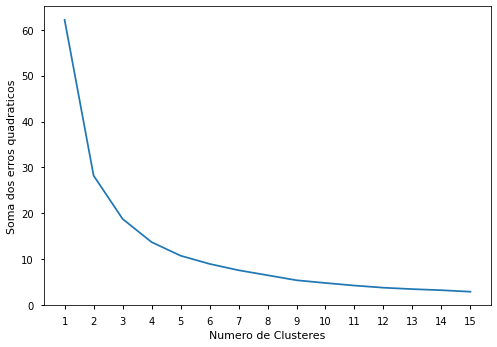

In [ ]:
# No preprocessador fazemos o uso de um MinMaxScaler pois os dados nao seguem uma distribuiução normal e uso de PCA para realiza a reduzir de dimensionalidade
preprocessor = Pipeline([("scaler", MinMaxScaler()), ("pca", PCA(n_components=2))])
kdados = np.array(scaler.fit_transform(dados.iloc[:,:]))

sumSqrErr = []
for k in range(1, 16):
  kkmeans = KMeans(n_clusters=k, n_init=16, max_iter=250 )
  clusterer = Pipeline([("kmeans", kkmeans)])
  pipe = Pipeline([("preprocessor", preprocessor),("clusterer", clusterer)])
  pipe.fit(kdados)
  sumSqrErr.append(kkmeans.inertia_)

# Plotando os dados
plt.style.use("seaborn-notebook")
plt.plot(range(1, 16), sumSqrErr)
plt.xticks(range(1, 16))
plt.xlabel("Numero de Clusteres")
plt.ylabel("Soma dos erros quadraticos")
plt.show()

In [ ]:
# Localizando o 'cotovelo'
kl = KneeLocator(range(1, 16), sumSqrErr, curve="convex", direction="decreasing")
print( "Um bom cotovelo: " + str(kl.elbow))

Um bom cotovelo: 4


O método do calculo do coeficiente de silhueta tem a finalidade de escolher de um número ótimo de grupos, avaliando os particionamentos encontrados. Ele é basicamente uma medida de coesão e separação do cluster. Ele quantifica o quão bem um ponto se encaixa no cluster ao qual ele foi atribuído.

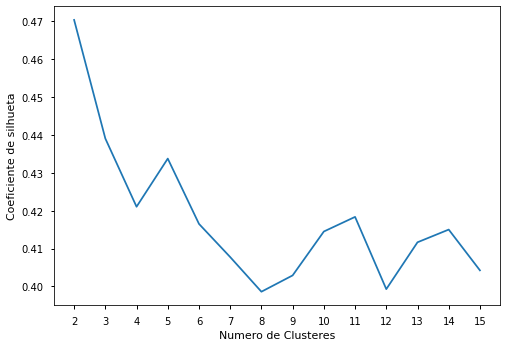

In [ ]:
coefSilhueta = []
for k in range(2, 16):
  kkmeans = KMeans(n_clusters=k, n_init=16, max_iter=250 )
  clusterer = Pipeline([("kmeans", kkmeans)])
  pipe = Pipeline([("preprocessor", preprocessor),("clusterer", clusterer)])
  pipe.fit(kdados)
  score = silhouette_score(pipe["preprocessor"].transform(kdados), kkmeans.labels_)
  coefSilhueta.append(score)

# Plotando o grafico
plt.style.use("seaborn-notebook")
plt.plot(range(2, 16), coefSilhueta)
plt.xticks(range(2, 16))
plt.xlabel("Numero de Clusteres")
plt.ylabel("Coeficiente de silhueta")
plt.show()


Iterações para convergir: 13

K-Means Inertia: 13.744366769468595

Coeficiente de silhueta: 0.42103873397474584



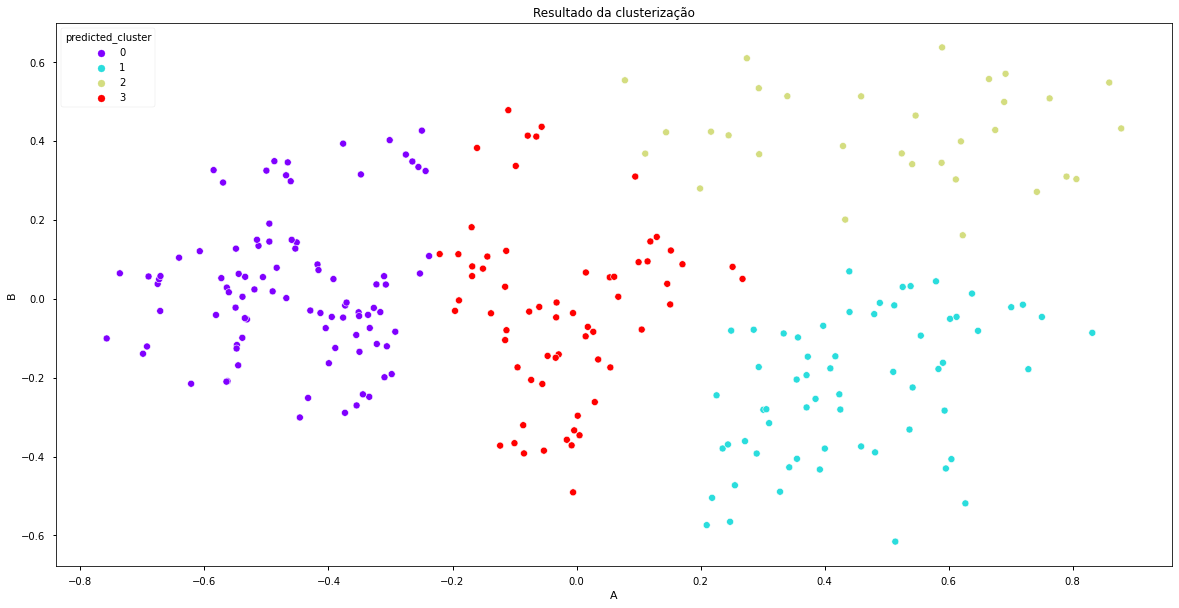

In [ ]:
# Definindo o clusterer como sendo o kmeans
kkmeans = KMeans(n_clusters=4, n_init=16, max_iter=250 )
clusterer = Pipeline([("kmeans",kkmeans)])
# Cria o pipeline
pipe = Pipeline([("preprocessor", preprocessor),("clusterer", clusterer)])

# Executa o pipeline
pipe.fit(kdados)

# Tansforma os dados
preprocessed_data = pipe["preprocessor"].transform(kdados)
predicted_labels = pipe["clusterer"]["kmeans"].labels_

# Plotado os dados
pcadf = pd.DataFrame( preprocessed_data, columns=["A", "B"])
pcadf["predicted_cluster"] = predicted_labels

plt.style.use("seaborn-notebook")
plt.figure(figsize=(20,10))

scat = sns.scatterplot("A", "B", data=pcadf, hue="predicted_cluster", palette="rainbow")
scat.set_title("Resultado da clusterização")

#print("\nCentros dos clusteres:\n" + str(kkmeans.cluster_centers_))
print("\nIterações para convergir: "+ str(kkmeans.n_iter_))
print("\nK-Means Inertia: "+ str(kkmeans.inertia_))
print("\nCoeficiente de silhueta: " + str(silhouette_score(preprocessed_data, kkmeans.labels_))+ "\n")

plt.show()


Iterações para convergir: 15

Coeficiente de silhueta: 0.42368194243909446



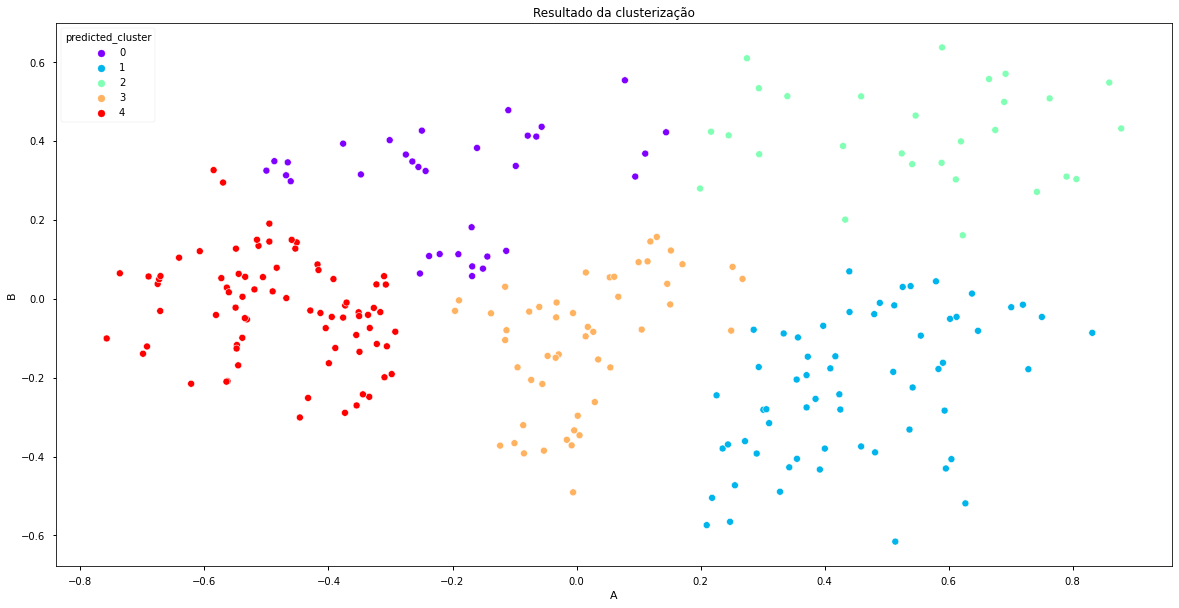

In [ ]:
# Definindo o clusterer como sendo o kmeans
kkmeans = KMeans(n_clusters=5, n_init=16, max_iter=250 )
clusterer = Pipeline([("kmeans",kkmeans)])
# Cria o pipeline
pipe = Pipeline([("preprocessor", preprocessor),("clusterer", clusterer)])

# Executa o pipeline
pipe.fit(kdados)

# Tansforma os dados
preprocessed_data = pipe["preprocessor"].transform(kdados)
predicted_labels = pipe["clusterer"]["kmeans"].labels_

# Plotado os dados
pcadf = pd.DataFrame( preprocessed_data, columns=["A", "B"])
pcadf["predicted_cluster"] = predicted_labels

plt.style.use("seaborn-notebook")
plt.figure(figsize=(20,10))

scat = sns.scatterplot("A", "B", data=pcadf, hue="predicted_cluster", palette="rainbow")
scat.set_title("Resultado da clusterização")

#print("\nCentros dos clusteres:\n" + str(kkmeans.cluster_centers_))
print("\nIterações para convergir: "+ str(kkmeans.n_iter_))
print("\nCoeficiente de silhueta: " + str(silhouette_score(preprocessed_data, predicted_labels))+ "\n")

plt.show()


Iterações para convergir: 13

Coeficiente de silhueta: 0.4203797250107233



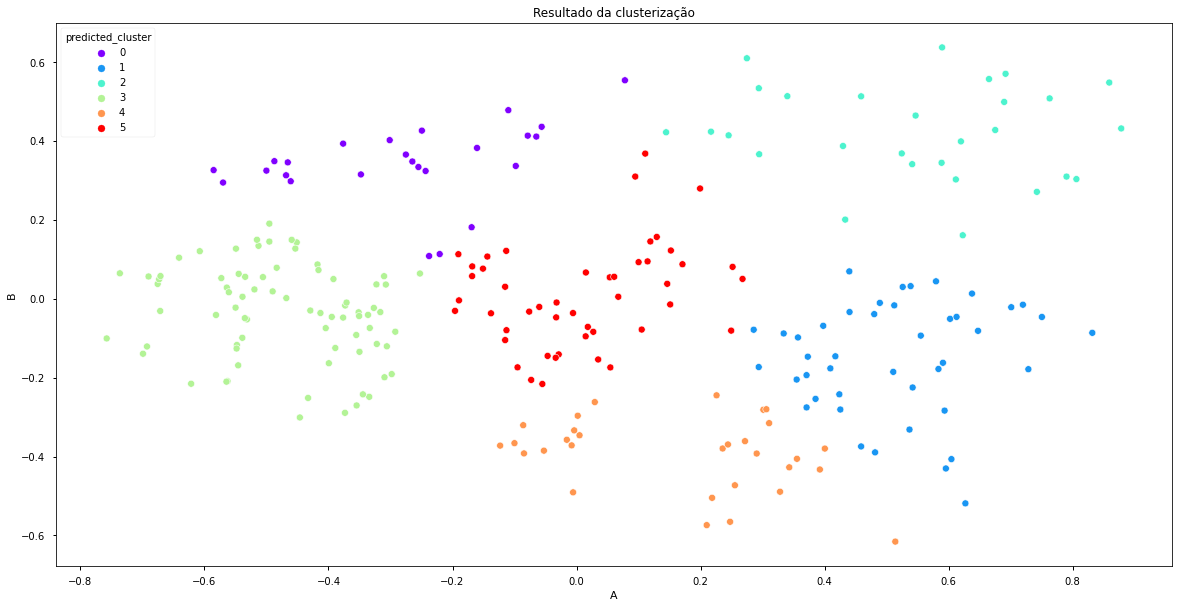

In [ ]:
# Definindo o clusterer como sendo o kmeans
kkmeans = KMeans(n_clusters=6, n_init=16, max_iter=250 )
clusterer = Pipeline([("kmeans",kkmeans)])
# Cria o pipeline
pipe = Pipeline([("preprocessor", preprocessor),("clusterer", clusterer)])

# Executa o pipeline
pipe.fit(kdados)

# Tansforma os dados
preprocessed_data = pipe["preprocessor"].transform(kdados)
predicted_labels = pipe["clusterer"]["kmeans"].labels_

# Plotado os dados
pcadf = pd.DataFrame( preprocessed_data, columns=["A", "B"])
pcadf["predicted_cluster"] = predicted_labels

plt.style.use("seaborn-notebook")
plt.figure(figsize=(20,10))

scat = sns.scatterplot("A", "B", data=pcadf, hue="predicted_cluster", palette="rainbow")
scat.set_title("Resultado da clusterização")

#print("\nCentros dos clusteres:\n" + str(kkmeans.cluster_centers_))
print("\nIterações para convergir: "+ str(kkmeans.n_iter_))
print("\nCoeficiente de silhueta: " + str(silhouette_score(preprocessed_data, predicted_labels))+ "\n")

plt.show()


Iterações para convergir: 4

Coeficiente de silhueta: 0.391446125651362



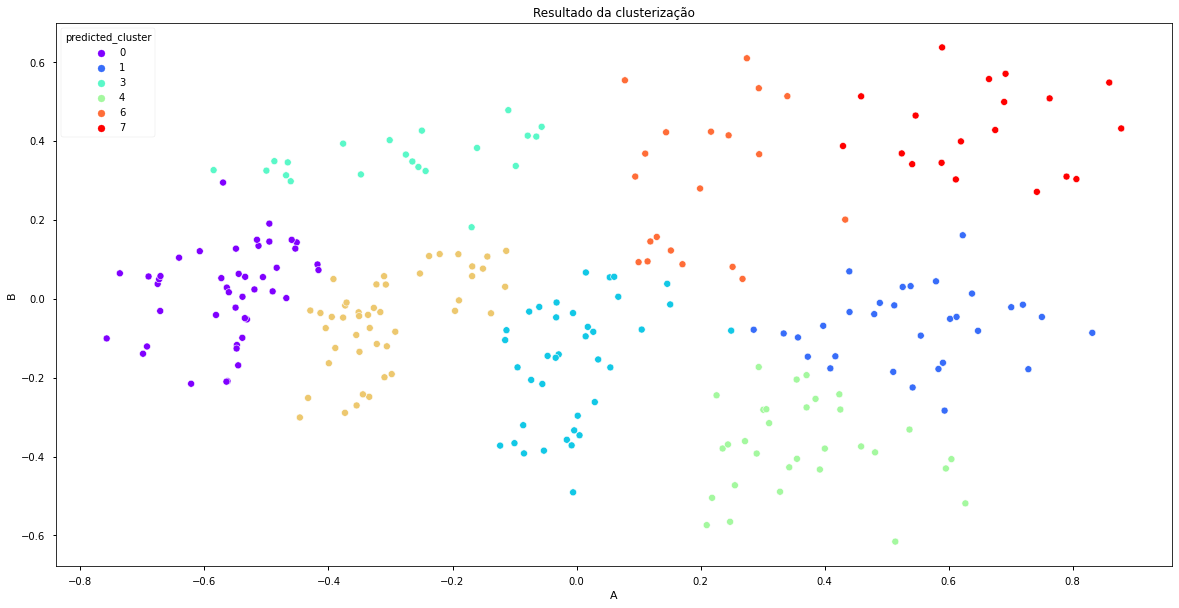

In [ ]:
# Definindo o clusterer como sendo o kmeans
kkmeans = KMeans(n_clusters=8, n_init=16, max_iter=250 )
clusterer = Pipeline([("kmeans",kkmeans)])
# Cria o pipeline
pipe = Pipeline([("preprocessor", preprocessor),("clusterer", clusterer)])

# Executa o pipeline
pipe.fit(kdados)

# Tansforma os dados
preprocessed_data = pipe["preprocessor"].transform(kdados)
predicted_labels = pipe["clusterer"]["kmeans"].labels_

# Plotado os dados
pcadf = pd.DataFrame( preprocessed_data, columns=["A", "B"])
pcadf["predicted_cluster"] = predicted_labels

plt.style.use("seaborn-notebook")
plt.figure(figsize=(20,10))

scat = sns.scatterplot("A", "B", data=pcadf, hue="predicted_cluster", palette="rainbow")
scat.set_title("Resultado da clusterização")

#print("\nCentros dos clusteres:\n" + str(kkmeans.cluster_centers_))
print("\nIterações para convergir: "+ str(kkmeans.n_iter_))
print("\nCoeficiente de silhueta: " + str(silhouette_score(preprocessed_data, predicted_labels))+ "\n")

plt.show()

## Análise final

De modo geral o k-means agrupou muito bem o conjunto dados para pca com n_components=2.

Utilizando os metodos do cotovelo e do coeficiente de silhueta para decidir o valor de k obtivemos bons resultados:
- Usando k (número de clusteres) = 4 e 6, que pareciam cotovelos e tinham bons coeficientes de silhueta, obtivemos uma boa divisao, com alguns clusteres pouco densos.
- Usando k = 5, que era um k com ótimo coeficiente de silhueta no gráfico, obtivemos uma excelente divisão. Todos os clusteres ficaram um numero parecido de objetos.
- Usando k = 8, que era o k com menor coeficiente de silhueta no gráfico, obtivemos clusteres muito densos e com muitos objetos e outros muito esparsos com poucos objetos.

#Inserindo os dados escalonados no array
Para a análise do Agrupamento Hierárquico e DBSCAN os dados devem estar formatados como array, utilizaremos o numpy para isso.


In [ ]:
dados = np.array(scaler.fit_transform(dados))
dados

array([[0.        , 0.17647059, 0.10150376, 0.06493506, 0.09836066,
        0.21656051],
       [0.        , 0.07843137, 0.09022556, 0.11038961, 0.10382514,
        0.04458599],
       [0.        , 0.        , 0.16917293, 0.18181818, 0.        ,
        0.08917197],
       ...,
       [0.7826087 , 0.48366013, 0.47368421, 0.29220779, 0.59016393,
        0.71974522],
       [0.7826087 , 0.54248366, 0.36466165, 0.51948052, 0.5136612 ,
        0.96815287],
       [0.7826087 , 0.60784314, 0.36466165, 0.51948052, 0.59562842,
        0.52229299]])

# Agrupamento hierárquico

Esse tipo de agrupamento é usado para verificar a distância entre os casos e agrupar os exemplos mais próximos. Para a análise serão utilizados três tipos de métodos, sendo eles o Ward, Complete e Average.

## Análise inicial

Serão verificados o dendograma e o plot de cada método, sendo os agrupamentos usando 4, 5, 6 e 8 clusters como padronização, o que permite uma comparação direta com o algoritmo K-Means.

## Método Ward

Nesse método a distância entre os casos é maior em relação aos outros métodos, mas o agrupamento no plot se mostrou mais próximo ao obtido no algoritmo K-Means para k=4 e k=5.

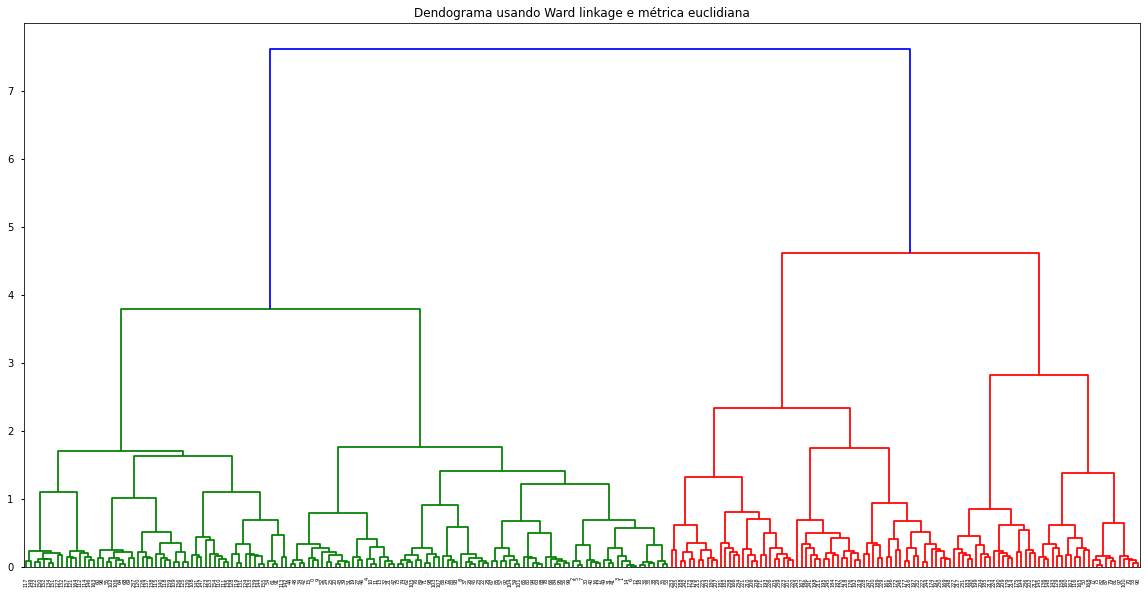

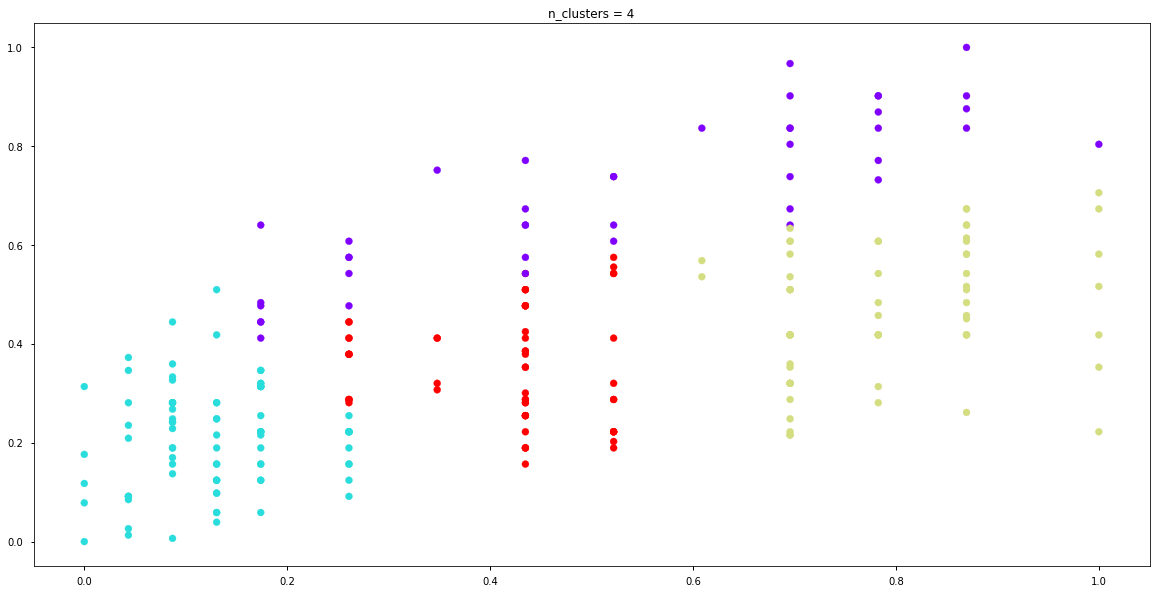

In [ ]:
plt.figure(figsize=(20,10))
plt.title("Dendograma usando Ward linkage e métrica euclidiana")
dend = sch.dendrogram(sch.linkage(dados, method='ward', metric='euclidean'))

euclidian_cluster = AgglomerativeClustering(n_clusters=4, affinity='euclidean', linkage='ward')
euclidian_cluster.fit_predict(dados)

plt.figure(figsize=(20,10))
plt.title("n_clusters = 4")
plt.scatter(dados[:,0], dados[:,1], c=euclidian_cluster.labels_, cmap='rainbow')

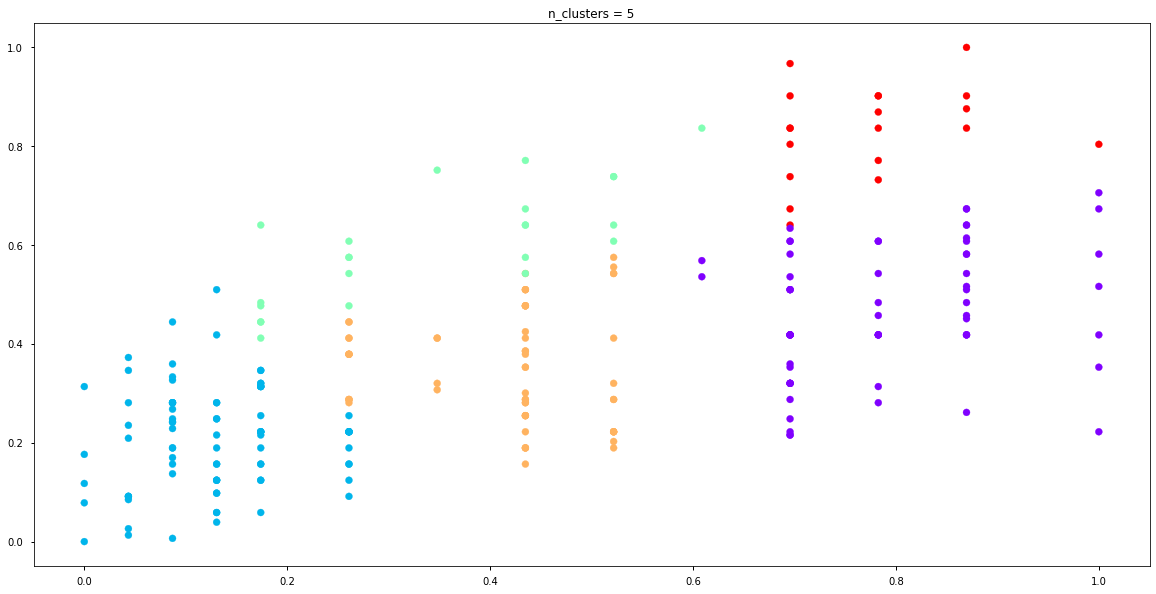

In [ ]:
euclidian_cluster = AgglomerativeClustering(n_clusters=5, affinity='euclidean', linkage='ward')
euclidian_cluster.fit_predict(dados)

plt.figure(figsize=(20,10))
plt.title("n_clusters = 5")
plt.scatter(dados[:,0], dados[:,1], c=euclidian_cluster.labels_, cmap='rainbow')

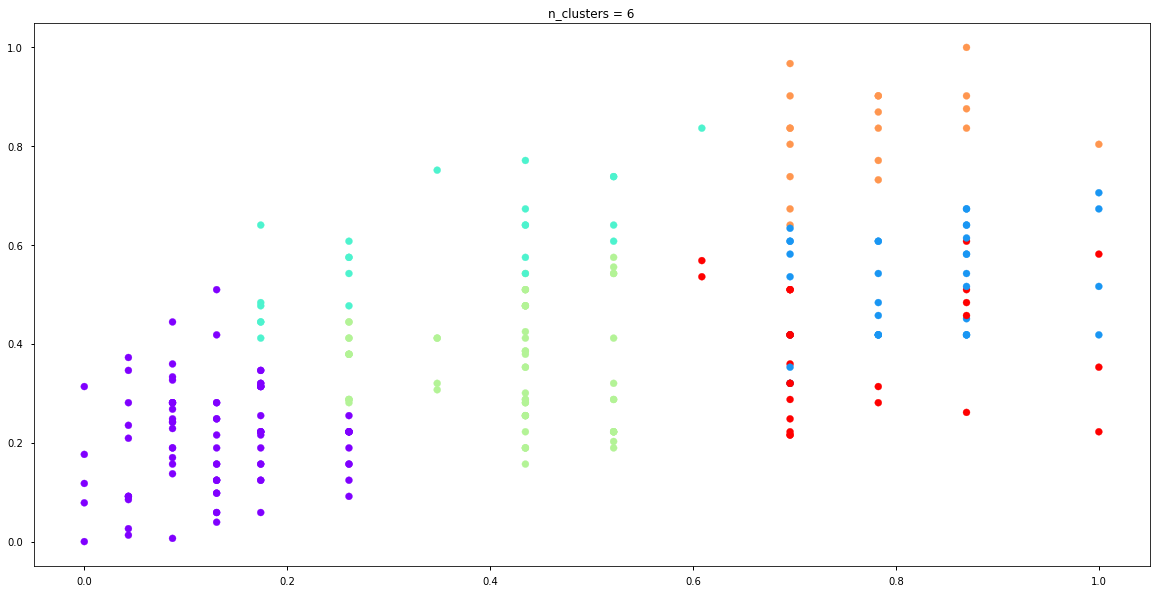

In [ ]:
euclidian_cluster = AgglomerativeClustering(n_clusters=6, affinity='euclidean', linkage='ward')
euclidian_cluster.fit_predict(dados)

plt.figure(figsize=(20,10))
plt.title("n_clusters = 6")
plt.scatter(dados[:,0], dados[:,1], c=euclidian_cluster.labels_, cmap='rainbow')

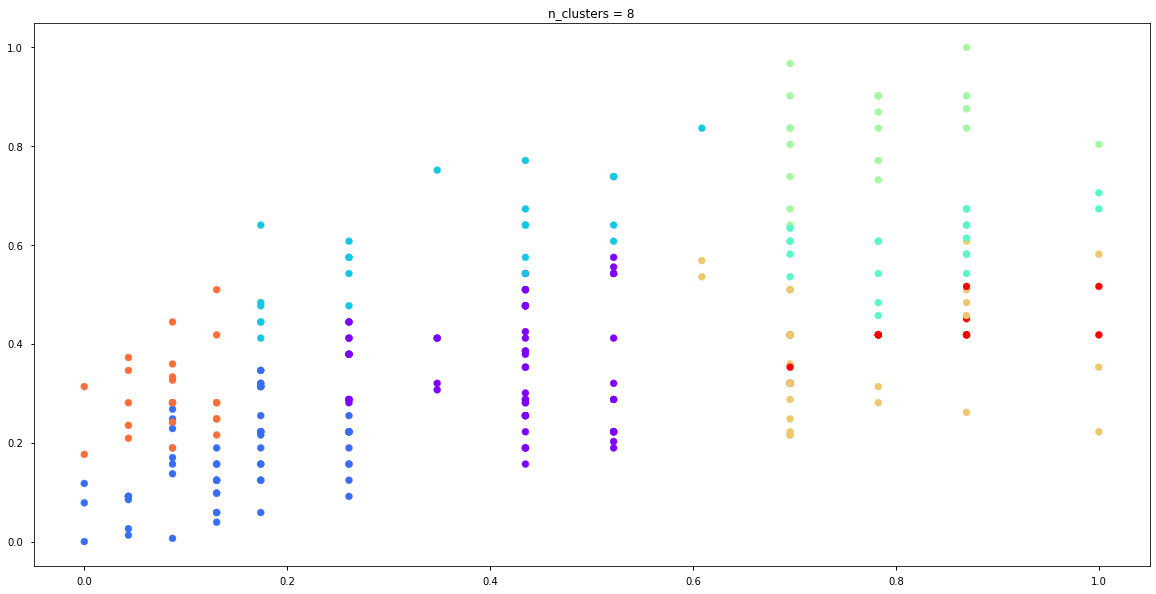

In [ ]:
euclidian_cluster = AgglomerativeClustering(n_clusters=8, affinity='euclidean', linkage='ward')
euclidian_cluster.fit_predict(dados)

plt.figure(figsize=(20,10))
plt.title("n_clusters = 8")
plt.scatter(dados[:,0], dados[:,1], c=euclidian_cluster.labels_, cmap='rainbow')

## Método Complete

A distância entre os agrupamentos é menor em relação ao Ward, mas é possível notar que alguns grupos ficam menores em comparação aos outros identificados em agrupamentos com mais de 6 clusters. No caso de n_clusters = 6, um grupo juntou casos que não pertenciam ao grupo quando n_clusters era menor.

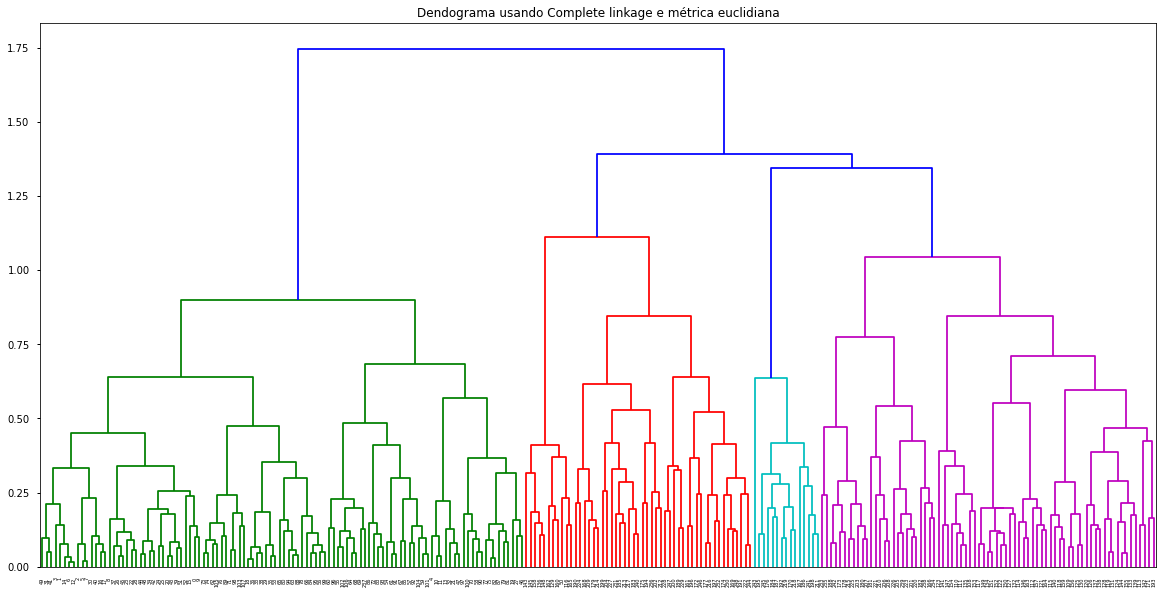

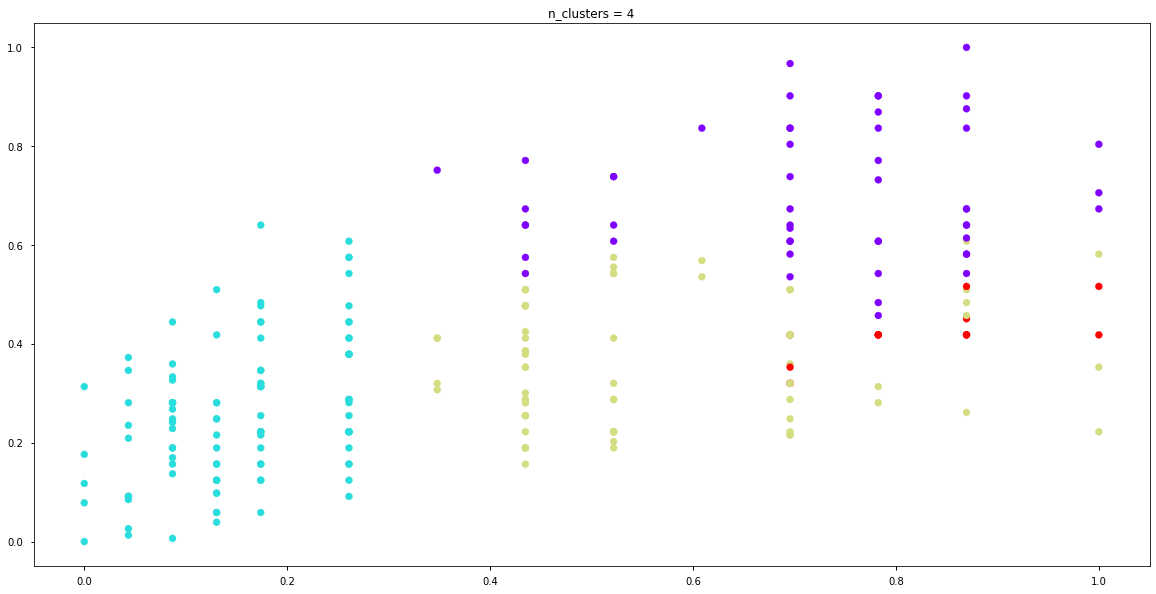

In [ ]:
plt.figure(figsize=(20,10))
plt.title("Dendograma usando Complete linkage e métrica euclidiana")
dend = sch.dendrogram(sch.linkage(dados, method='complete', metric='euclidean'))

euclidian_cluster = AgglomerativeClustering(n_clusters=4, affinity='euclidean', linkage='complete')
euclidian_cluster.fit_predict(dados)

plt.figure(figsize=(20,10))
plt.title("n_clusters = 4")
plt.scatter(dados[:,0], dados[:,1], c=euclidian_cluster.labels_, cmap='rainbow')

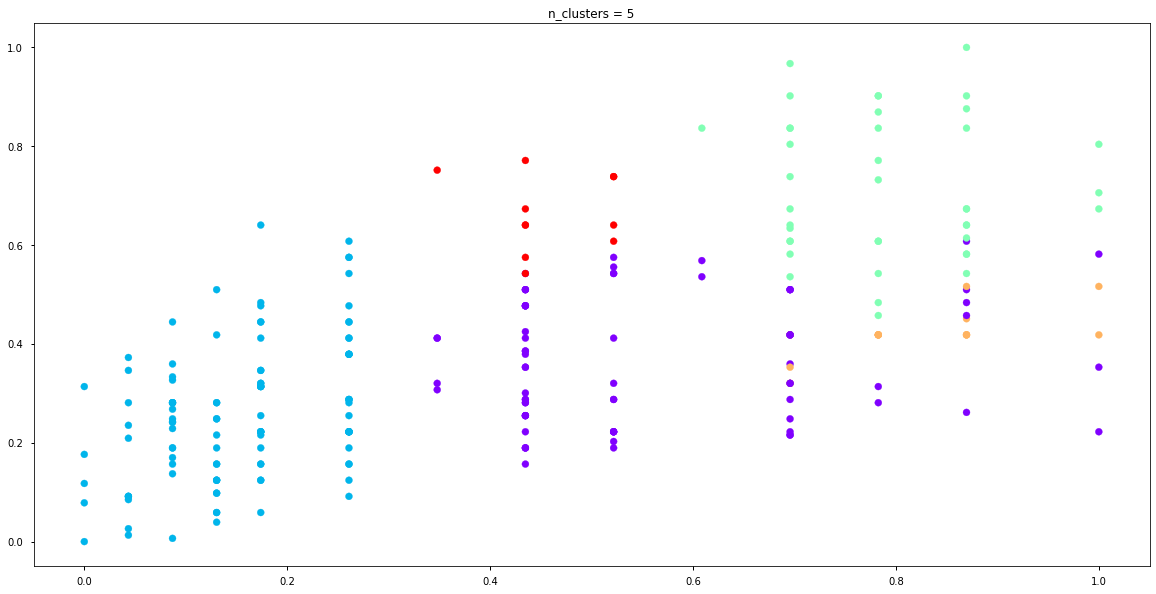

In [ ]:
euclidian_cluster = AgglomerativeClustering(n_clusters=5, affinity='euclidean', linkage='complete')
euclidian_cluster.fit_predict(dados)

plt.figure(figsize=(20,10))
plt.title("n_clusters = 5")
plt.scatter(dados[:,0], dados[:,1], c=euclidian_cluster.labels_, cmap='rainbow')

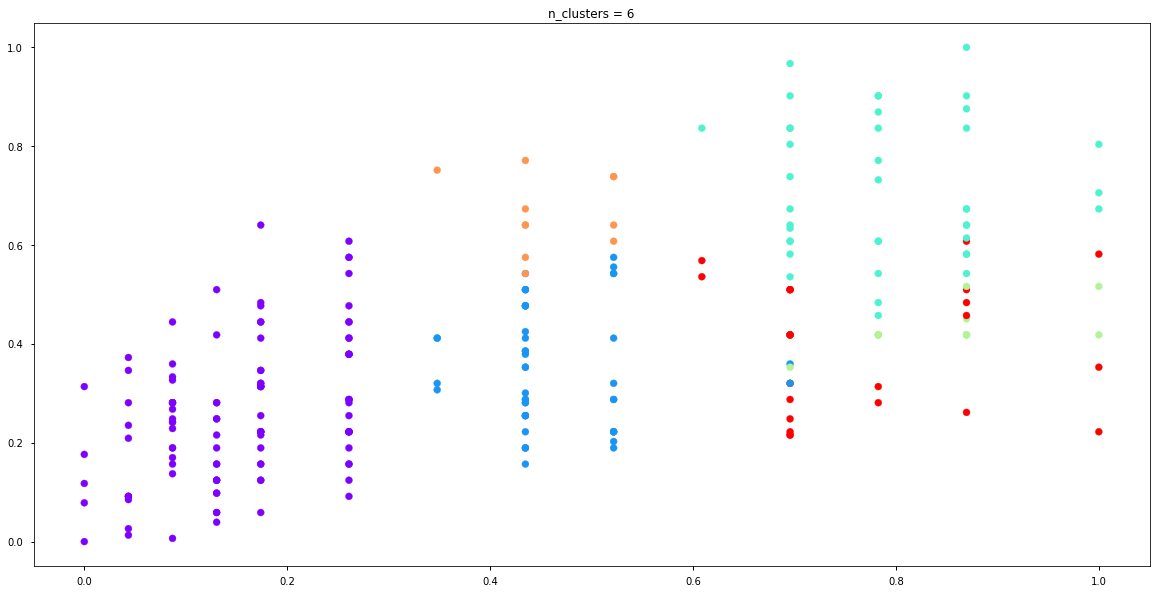

In [ ]:
euclidian_cluster = AgglomerativeClustering(n_clusters=6, affinity='euclidean', linkage='complete')
euclidian_cluster.fit_predict(dados)

plt.figure(figsize=(20,10))
plt.title("n_clusters = 6")
plt.scatter(dados[:,0], dados[:,1], c=euclidian_cluster.labels_, cmap='rainbow')

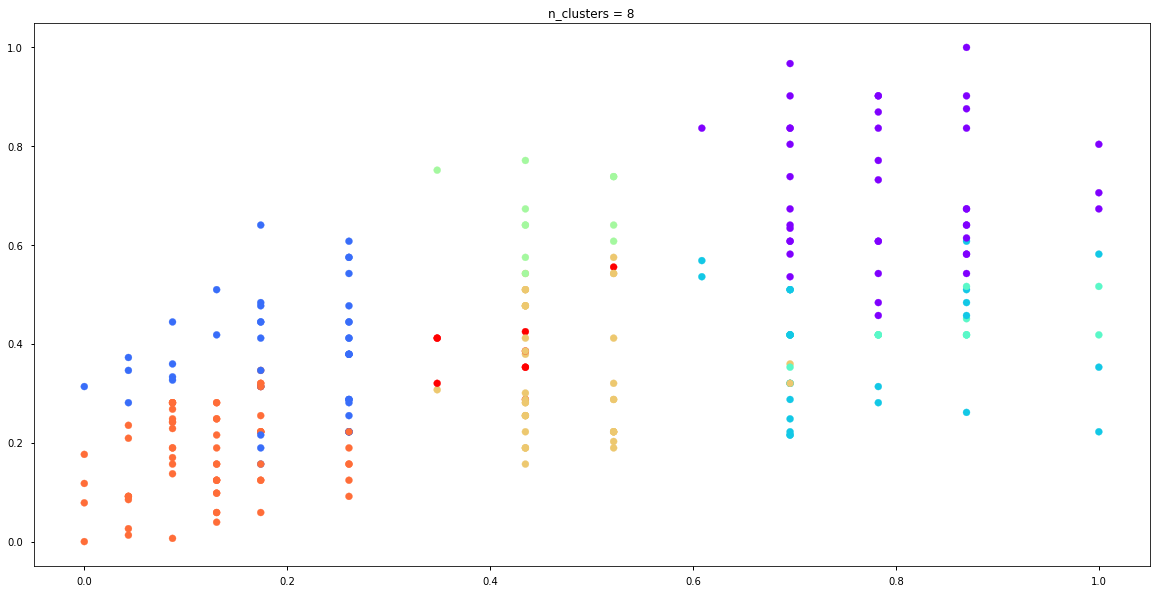

In [ ]:
euclidian_cluster = AgglomerativeClustering(n_clusters=8, affinity='euclidean', linkage='complete')
euclidian_cluster.fit_predict(dados)

plt.figure(figsize=(20,10))
plt.title("n_clusters = 8")
plt.scatter(dados[:,0], dados[:,1], c=euclidian_cluster.labels_, cmap='rainbow')

## Método Average

Para o método average é possível notar no dendograma que a distância entre os agrupamentos é menor, sendo a maioria das uniões ocorrendo entre distâncias menores que 1. No entanto, os resultados mostram que o agrupamento não é eficiente, visto que para todos os valores de n_clusters há um grupo com apenas um ou dois casos.

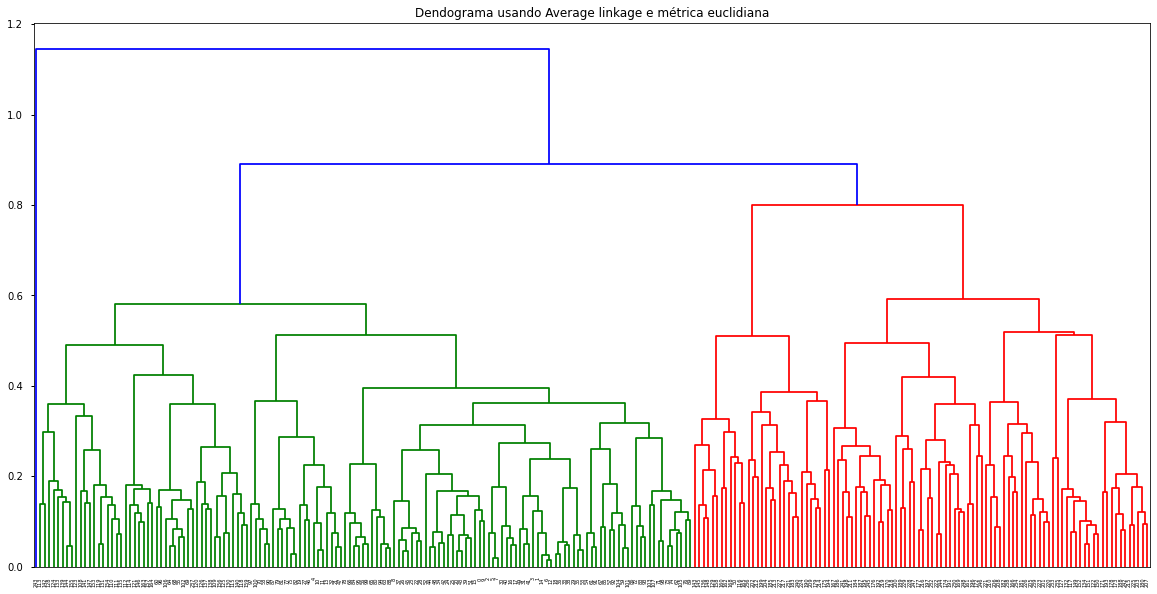

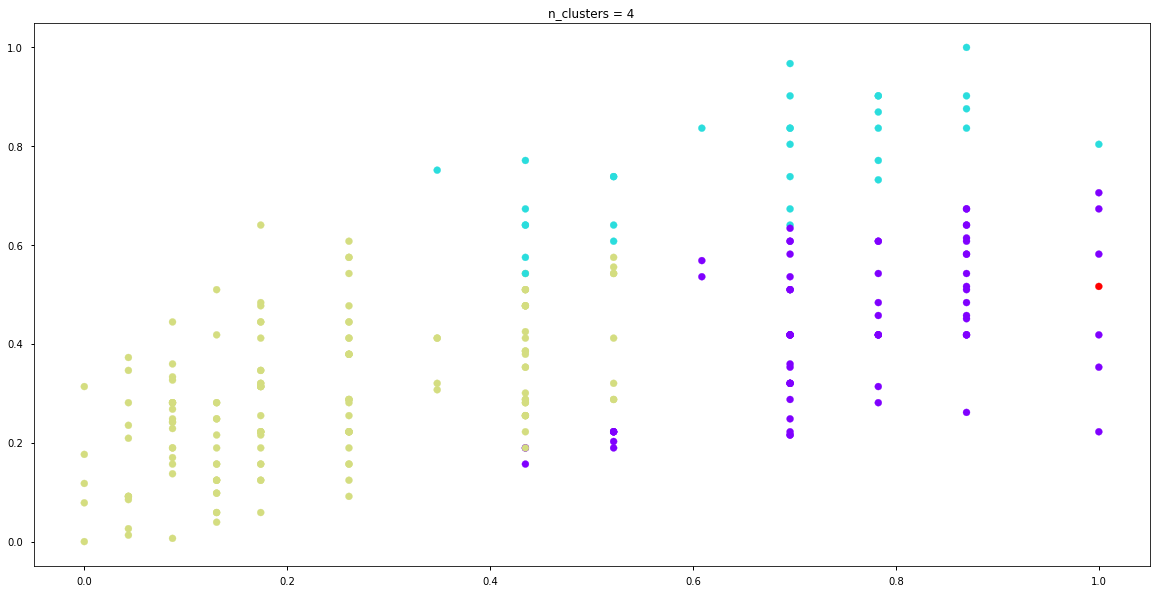

In [ ]:
plt.figure(figsize=(20,10))
plt.title("Dendograma usando Average linkage e métrica euclidiana")
dend = sch.dendrogram(sch.linkage(dados, method='average', metric='euclidean'))

euclidian_cluster = AgglomerativeClustering(n_clusters=4, affinity='euclidean', linkage='average')
euclidian_cluster.fit_predict(dados)

plt.figure(figsize=(20,10))
plt.title("n_clusters = 4")
plt.scatter(dados[:,0], dados[:,1], c=euclidian_cluster.labels_, cmap='rainbow')

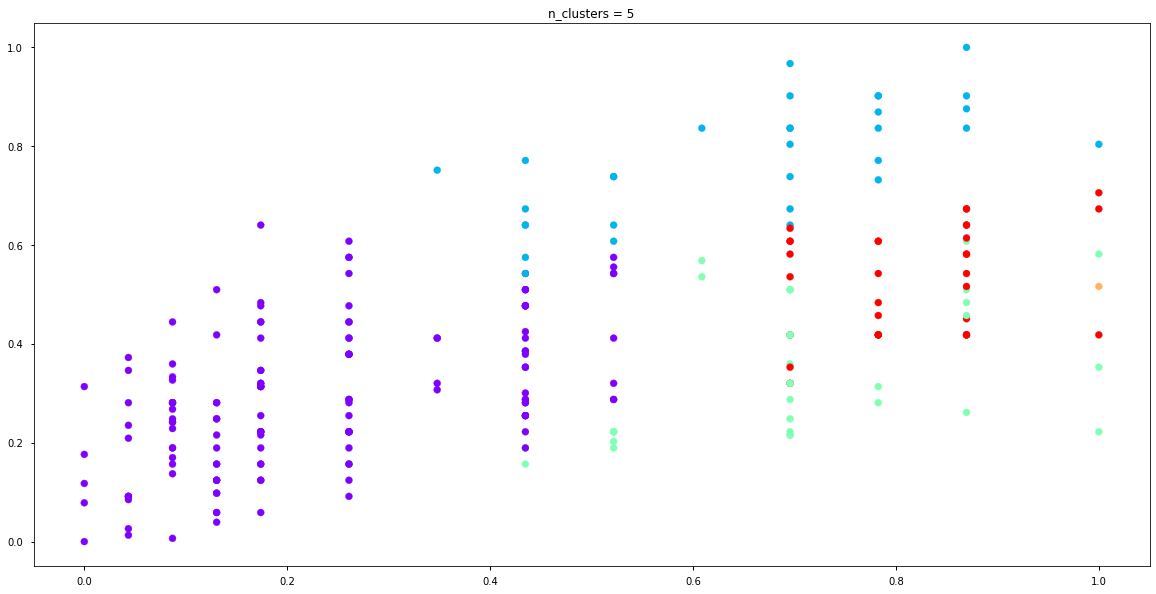

In [ ]:
euclidian_cluster = AgglomerativeClustering(n_clusters=5, affinity='euclidean', linkage='average')
euclidian_cluster.fit_predict(dados)

plt.figure(figsize=(20,10))
plt.title("n_clusters = 5")
plt.scatter(dados[:,0], dados[:,1], c=euclidian_cluster.labels_, cmap='rainbow')

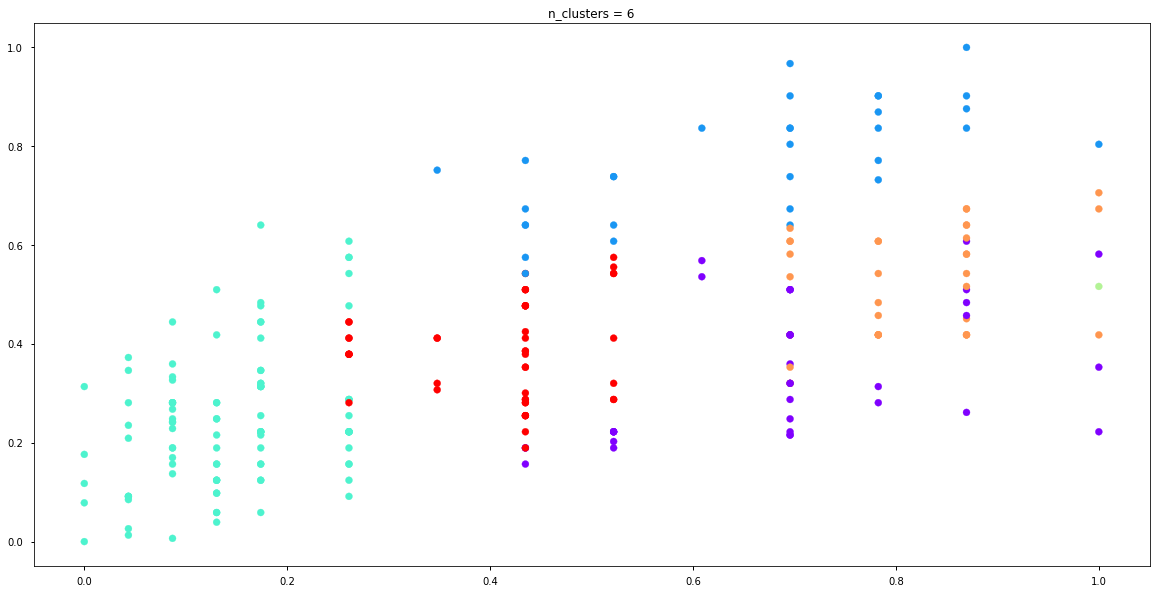

In [ ]:
euclidian_cluster = AgglomerativeClustering(n_clusters=6, affinity='euclidean', linkage='average')
euclidian_cluster.fit_predict(dados)

plt.figure(figsize=(20,10))
plt.title("n_clusters = 6")
plt.scatter(dados[:,0], dados[:,1], c=euclidian_cluster.labels_, cmap='rainbow')

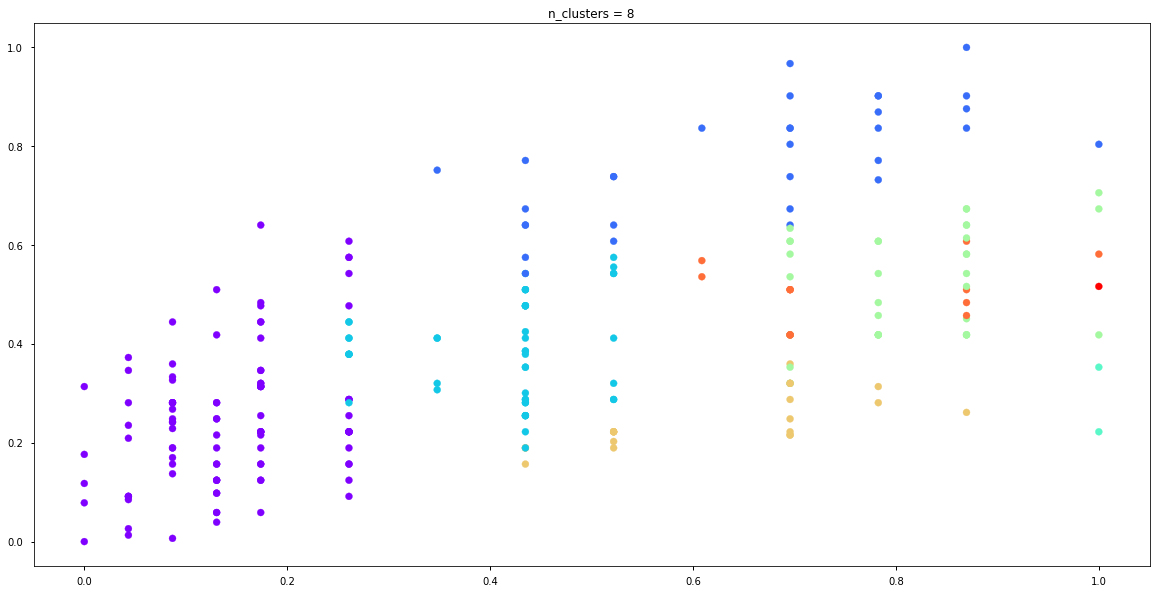

In [ ]:
euclidian_cluster = AgglomerativeClustering(n_clusters=8, affinity='euclidean', linkage='average')
euclidian_cluster.fit_predict(dados)

plt.figure(figsize=(20,10))
plt.title("n_clusters = 8")
plt.scatter(dados[:,0], dados[:,1], c=euclidian_cluster.labels_, cmap='rainbow')

## Análise final

Observando as três métricas aplicadas em um mesmo dataset, é possível notar que a métrica Ward foi mais eficiente para agrupar os dados em casos de 4 a 6 clusters. Embora os resultados tenham sido semelhantes para 4 e 5 grupos, quando foi feito o agrupamento com n_clusters = 6, um dos grupos ficou maior em relação aos outros. No caso da métrica Average um dos grupos foi tratado como um outlier em relação aos outros, independente do número de clusters.

Levando em consideração os dendogramas, a maior distância entre os agrupamentos está no dendograma da métrica Ward. Enquanto a métrica Complete e Average possuem distância entre 0 e 1 para formar 6 grupos, o corte da métrica Ward é maior que 2 para chegar no mesmo número de clusters.

Também foi possível notar que 8 clusters é ineficiente para agrupar o dataset, sendo um valor muito grande para tratar apenas 249 exemplos.

#DBSCAN
Encontra amostras de núcleo de alta densidade e expande os clusters a partir delas. Bom para dados que contêm clusters de densidade semelhante.

##Análise inicial

Agora iremos utilizar o DBSCAN, os hiperparâmetros utilizados sera _eps_ (a distância máxima entre duas amostras para que uma seja considerada próxima da outra) e _min_samples_ (número de amostras em uma vizinhança para um ponto a ser considerado como um ponto central incluindo o próprio ponto.)
O _core_samples_mask_ ira armazenar os índices dos cores utilizando _boolean_ (usando np.zero_like armazenando todos os False, em sequencia inserindo True nos índices dos cores).


In [ ]:
db = DBSCAN(eps=0.12, min_samples=6).fit(dados) 
core_samples_mask = np.zeros_like(db.labels_, dtype=bool)
core_samples_mask[db.core_sample_indices_] = True
labels = db.labels_

### Observar a média de tempo
A média encontrada varia entre 0.0020 e 0.0022 segundos aproximadamente.

In [68]:
import time
soma =0

for i in range(0, 1000):
  inicio = time.time()
  db = DBSCAN(eps=0.2, min_samples=6).fit(dados) 
  core_samples_mask = np.zeros_like(db.labels_, dtype=bool)
  core_samples_mask[db.core_sample_indices_] = True
  labels = db.labels_
  fim = time.time()
  soma += (fim - inicio)
print(soma/1000)

0.0020376574993133546


### Calcular o número de clusters
O número de clusters se baseia em numero de rótulos (db.labels_), mas caso exista algum ruído (marcado como -1 nos rotulos) deve subtrair 1 desse cálculo.

In [ ]:
n_clusters_ = len(set(labels)) - (1 if -1 in labels else 0)

###Plotar resultados
Inicialmente definimos as cores para cada rótulo, em seguida com _zip_ iremos gerar tuples para fazer seus plots, os _cores_ serão maiores, outliers serão menores da mesma cor do _core_ e ruídos serão pequenos e pretos.


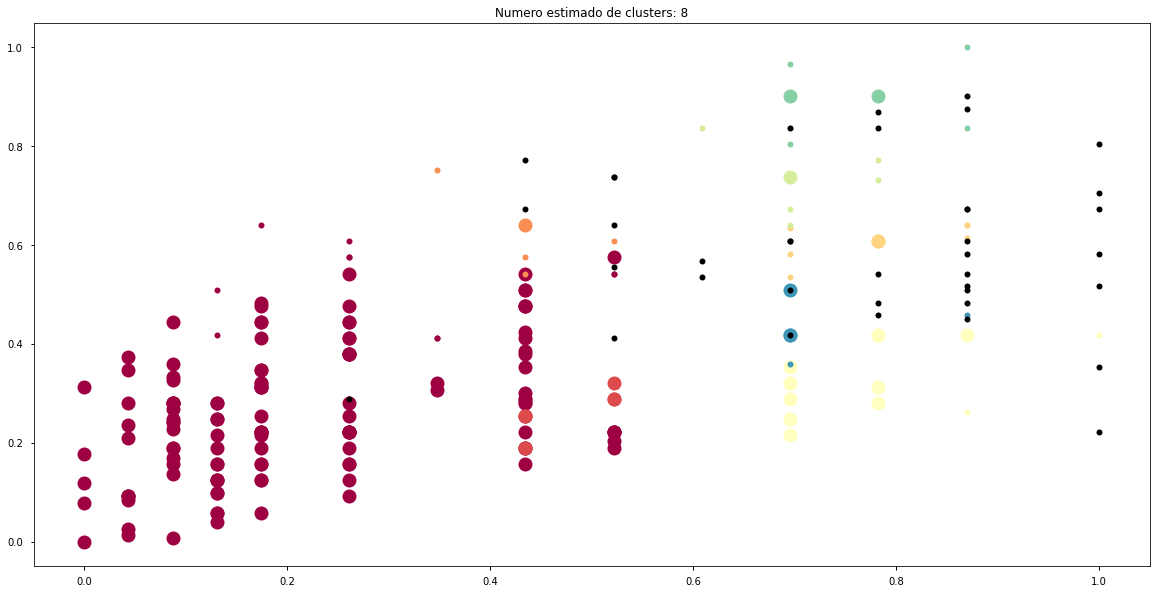

In [ ]:
plt.figure(figsize=(20,10))
unique_labels = set(labels)
colors = [plt.cm.Spectral(each)
          for each in np.linspace(0, 1, len(unique_labels))]
for k, col in zip(unique_labels, colors):
    if k == -1:        
        col = [0, 0, 0, 1] #Para os pontos de ruido

    class_member_mask = (labels == k)

    xy = dados[class_member_mask & core_samples_mask] #plota os core
    plt.plot(xy[:, 0], xy[:, 1], 'o', markerfacecolor=tuple(col),
             markeredgecolor='k', markersize=14)

    #outliers
    xy = dados[class_member_mask & ~core_samples_mask] #plota os outliers
    plt.plot(xy[:, 0], xy[:, 1], 'o', markerfacecolor=tuple(col),
             markeredgecolor='k', markersize=6)


plt.title('Numero estimado de clusters: %d' % n_clusters_)
plt.show()

## Modificando hiperparâmetros

###Diminuindo eps

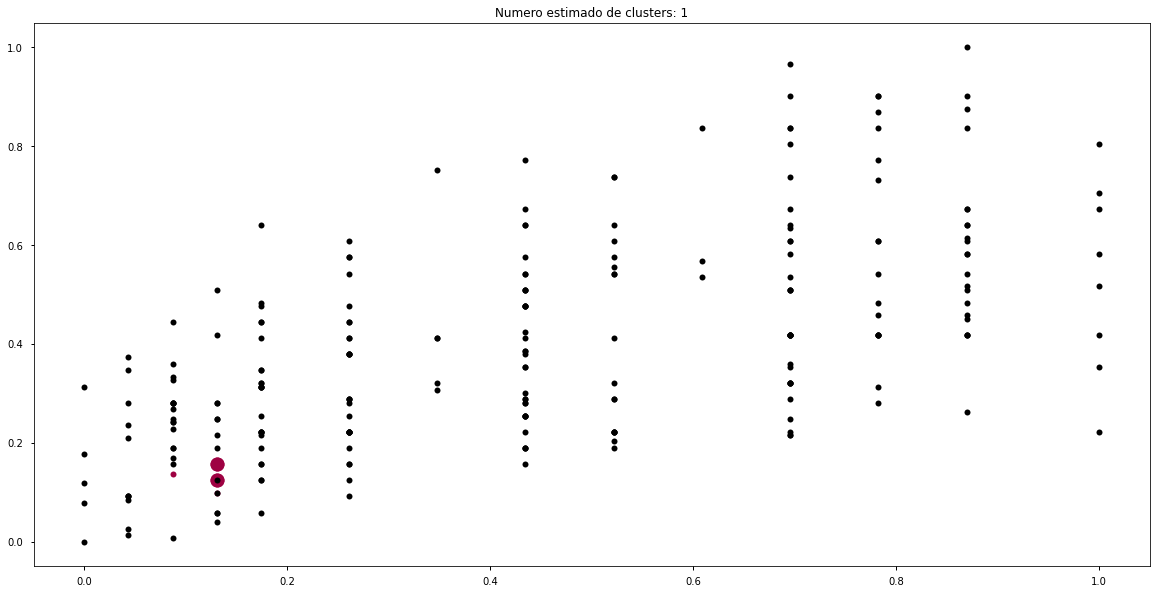

In [ ]:
db = DBSCAN(eps=0.10, min_samples=6).fit(dados) 
core_samples_mask = np.zeros_like(db.labels_, dtype=bool)
core_samples_mask[db.core_sample_indices_] = True
labels = db.labels_

n_clusters_ = len(set(labels)) - (1 if -1 in labels else 0)

plt.figure(figsize=(20,10))
unique_labels = set(labels)
colors = [plt.cm.Spectral(each)
          for each in np.linspace(0, 1, len(unique_labels))]
for k, col in zip(unique_labels, colors):
    if k == -1:        
        col = [0, 0, 0, 1] #Para os pontos de ruido

    class_member_mask = (labels == k)

    xy = dados[class_member_mask & core_samples_mask] #plota os core
    plt.plot(xy[:, 0], xy[:, 1], 'o', markerfacecolor=tuple(col),
             markeredgecolor='k', markersize=14)

    #outliers
    xy = dados[class_member_mask & ~core_samples_mask] #plota os outliers
    plt.plot(xy[:, 0], xy[:, 1], 'o', markerfacecolor=tuple(col),
             markeredgecolor='k', markersize=6)


plt.title('Numero estimado de clusters: %d' % n_clusters_)
plt.show()

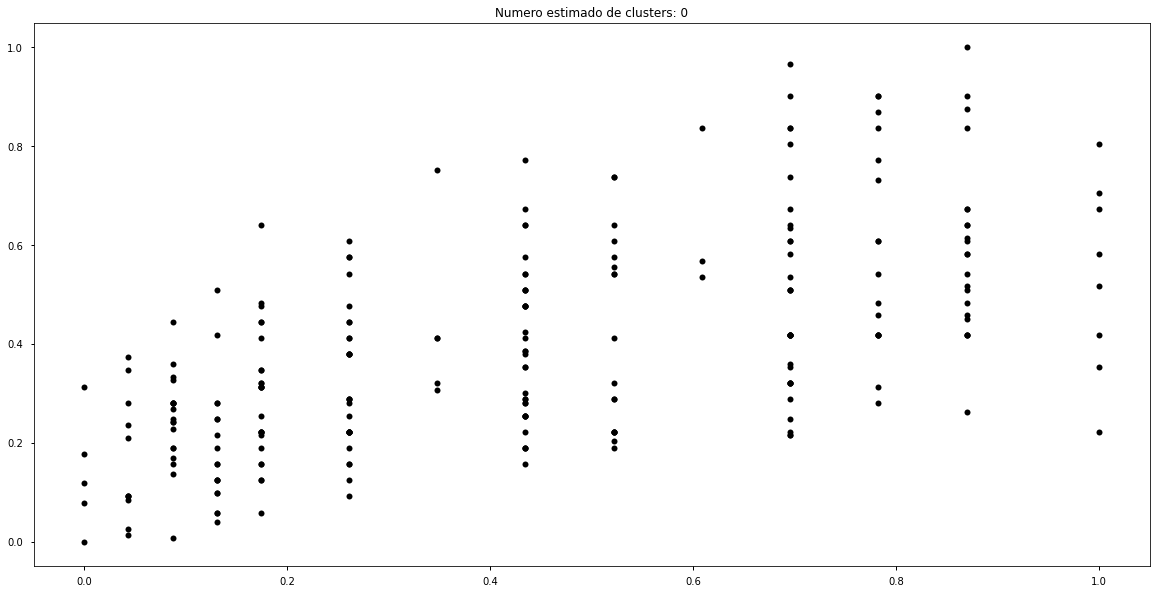

In [ ]:
db = DBSCAN(eps=0.01, min_samples=6).fit(dados) 
core_samples_mask = np.zeros_like(db.labels_, dtype=bool)
core_samples_mask[db.core_sample_indices_] = True
labels = db.labels_

n_clusters_ = len(set(labels)) - (1 if -1 in labels else 0)

plt.figure(figsize=(20,10))
unique_labels = set(labels)
colors = [plt.cm.Spectral(each)
          for each in np.linspace(0, 1, len(unique_labels))]
for k, col in zip(unique_labels, colors):
    if k == -1:        
        col = [0, 0, 0, 1] #Para os pontos de ruido

    class_member_mask = (labels == k)

    xy = dados[class_member_mask & core_samples_mask] #plota os core
    plt.plot(xy[:, 0], xy[:, 1], 'o', markerfacecolor=tuple(col),
             markeredgecolor='k', markersize=14)

    #outliers
    xy = dados[class_member_mask & ~core_samples_mask] #plota os outliers
    plt.plot(xy[:, 0], xy[:, 1], 'o', markerfacecolor=tuple(col),
             markeredgecolor='k', markersize=6)


plt.title('Numero estimado de clusters: %d' % n_clusters_)
plt.show()

###Aumentando eps

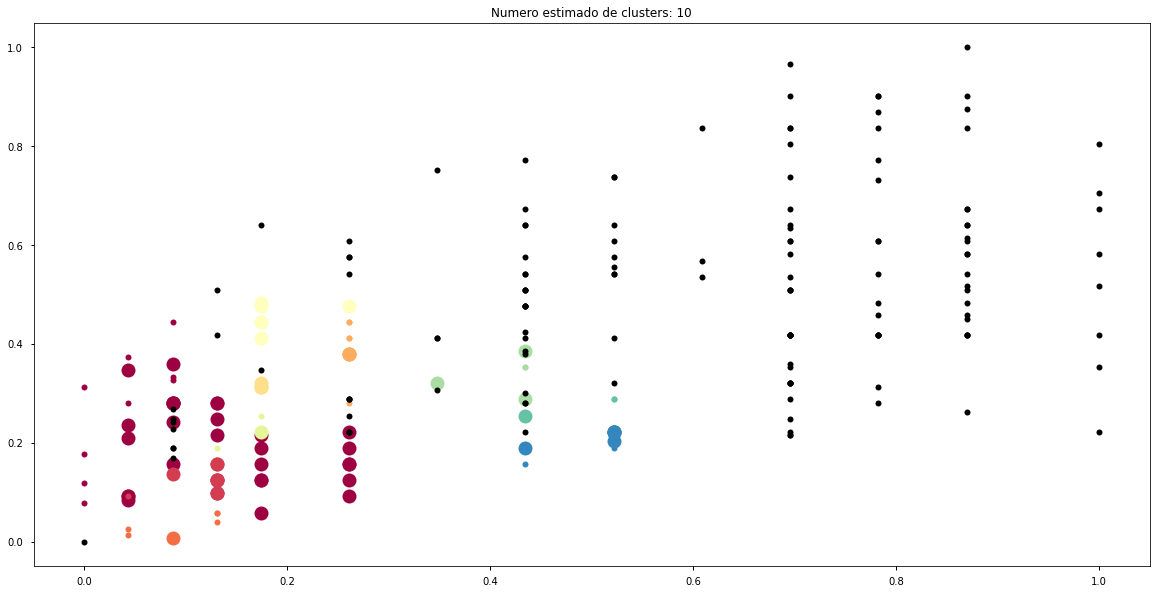

In [ ]:
db = DBSCAN(eps=0.15, min_samples=6).fit(dados) 
core_samples_mask = np.zeros_like(db.labels_, dtype=bool)
core_samples_mask[db.core_sample_indices_] = True
labels = db.labels_

n_clusters_ = len(set(labels)) - (1 if -1 in labels else 0)

plt.figure(figsize=(20,10))
unique_labels = set(labels)
colors = [plt.cm.Spectral(each)
          for each in np.linspace(0, 1, len(unique_labels))]
for k, col in zip(unique_labels, colors):
    if k == -1:        
        col = [0, 0, 0, 1] #Para os pontos de ruido

    class_member_mask = (labels == k)

    xy = dados[class_member_mask & core_samples_mask] #plota os core
    plt.plot(xy[:, 0], xy[:, 1], 'o', markerfacecolor=tuple(col),
             markeredgecolor='k', markersize=14)

    #outliers
    xy = dados[class_member_mask & ~core_samples_mask] #plota os outliers
    plt.plot(xy[:, 0], xy[:, 1], 'o', markerfacecolor=tuple(col),
             markeredgecolor='k', markersize=6)


plt.title('Numero estimado de clusters: %d' % n_clusters_)
plt.show()

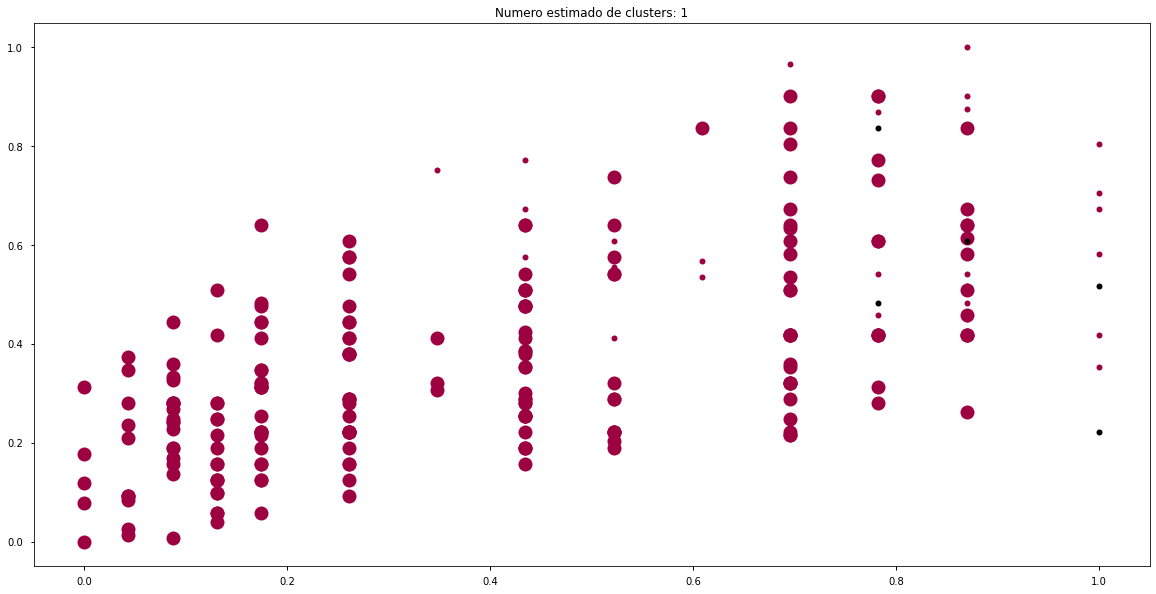

In [ ]:
db = DBSCAN(eps=0.26, min_samples=6).fit(dados) 
core_samples_mask = np.zeros_like(db.labels_, dtype=bool)
core_samples_mask[db.core_sample_indices_] = True
labels = db.labels_

n_clusters_ = len(set(labels)) - (1 if -1 in labels else 0)

plt.figure(figsize=(20,10))
unique_labels = set(labels)
colors = [plt.cm.Spectral(each)
          for each in np.linspace(0, 1, len(unique_labels))]
for k, col in zip(unique_labels, colors):
    if k == -1:        
        col = [0, 0, 0, 1] #Para os pontos de ruido

    class_member_mask = (labels == k)

    xy = dados[class_member_mask & core_samples_mask] #plota os core
    plt.plot(xy[:, 0], xy[:, 1], 'o', markerfacecolor=tuple(col),
             markeredgecolor='k', markersize=14)

    #outliers
    xy = dados[class_member_mask & ~core_samples_mask] #plota os outliers
    plt.plot(xy[:, 0], xy[:, 1], 'o', markerfacecolor=tuple(col),
             markeredgecolor='k', markersize=6)


plt.title('Numero estimado de clusters: %d' % n_clusters_)
plt.show()

###Diminuindo min_samples

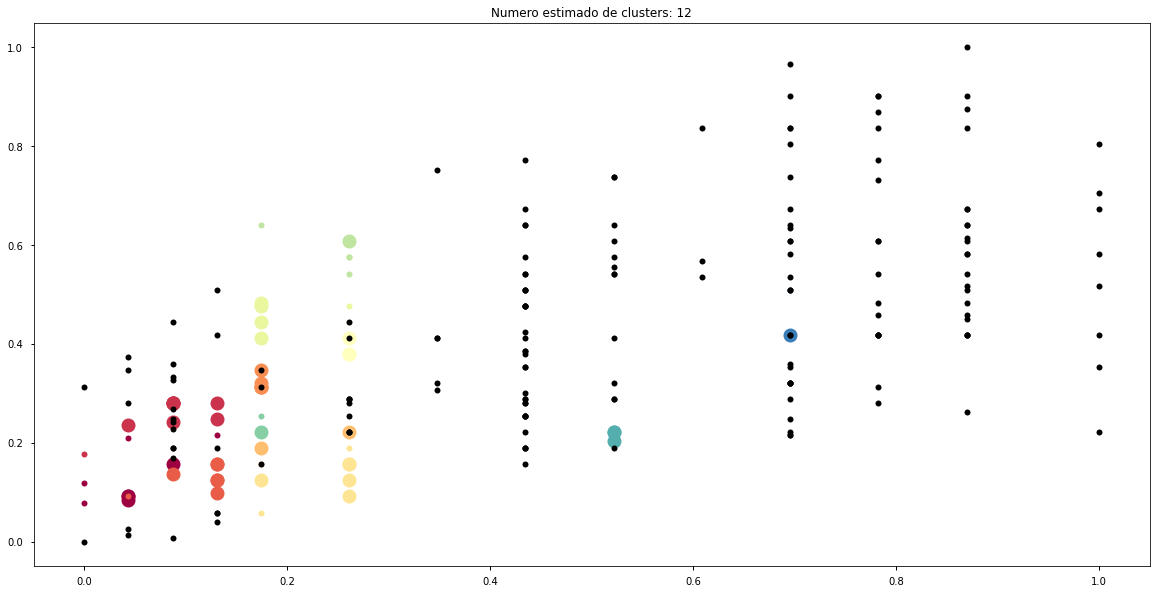

In [ ]:
db = DBSCAN(eps=0.12, min_samples=5).fit(dados) 
core_samples_mask = np.zeros_like(db.labels_, dtype=bool)
core_samples_mask[db.core_sample_indices_] = True
labels = db.labels_

n_clusters_ = len(set(labels)) - (1 if -1 in labels else 0)

plt.figure(figsize=(20,10))
unique_labels = set(labels)
colors = [plt.cm.Spectral(each)
          for each in np.linspace(0, 1, len(unique_labels))]
for k, col in zip(unique_labels, colors):
    if k == -1:        
        col = [0, 0, 0, 1] #Para os pontos de ruido

    class_member_mask = (labels == k)

    xy = dados[class_member_mask & core_samples_mask] #plota os core
    plt.plot(xy[:, 0], xy[:, 1], 'o', markerfacecolor=tuple(col),
             markeredgecolor='k', markersize=14)

    #outliers
    xy = dados[class_member_mask & ~core_samples_mask] #plota os outliers
    plt.plot(xy[:, 0], xy[:, 1], 'o', markerfacecolor=tuple(col),
             markeredgecolor='k', markersize=6)


plt.title('Numero estimado de clusters: %d' % n_clusters_)
plt.show()

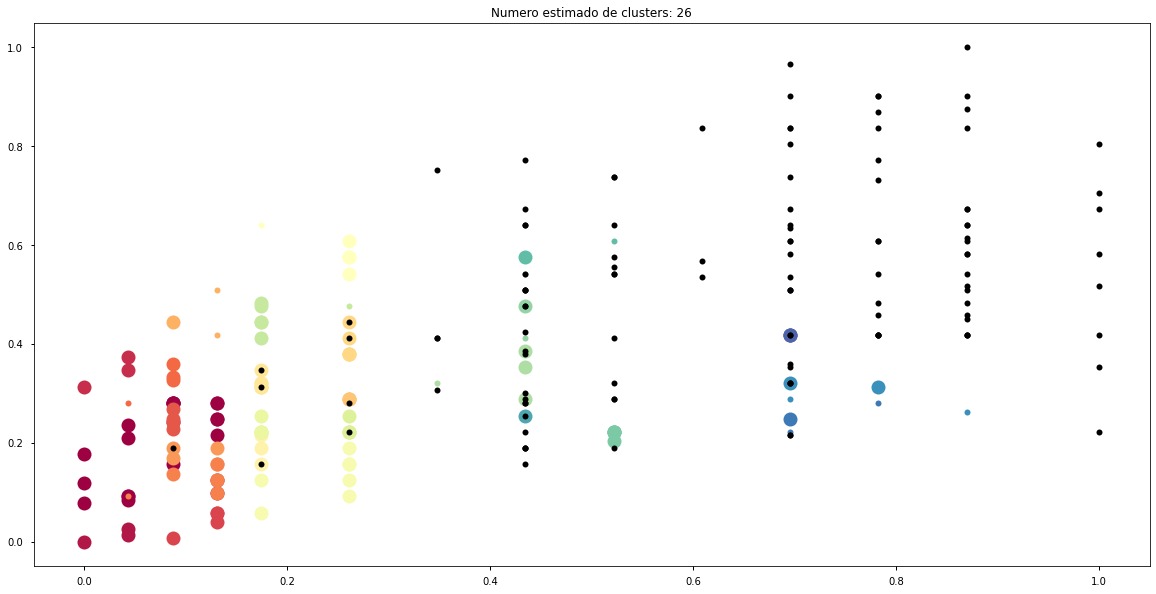

In [ ]:
db = DBSCAN(eps=0.12, min_samples=3).fit(dados) 
core_samples_mask = np.zeros_like(db.labels_, dtype=bool)
core_samples_mask[db.core_sample_indices_] = True
labels = db.labels_

n_clusters_ = len(set(labels)) - (1 if -1 in labels else 0)

plt.figure(figsize=(20,10))
unique_labels = set(labels)
colors = [plt.cm.Spectral(each)
          for each in np.linspace(0, 1, len(unique_labels))]
for k, col in zip(unique_labels, colors):
    if k == -1:        
        col = [0, 0, 0, 1] #Para os pontos de ruido

    class_member_mask = (labels == k)

    xy = dados[class_member_mask & core_samples_mask] #plota os core
    plt.plot(xy[:, 0], xy[:, 1], 'o', markerfacecolor=tuple(col),
             markeredgecolor='k', markersize=14)

    #outliers
    xy = dados[class_member_mask & ~core_samples_mask] #plota os outliers
    plt.plot(xy[:, 0], xy[:, 1], 'o', markerfacecolor=tuple(col),
             markeredgecolor='k', markersize=6)


plt.title('Numero estimado de clusters: %d' % n_clusters_)
plt.show()

###Aumentando min_samples

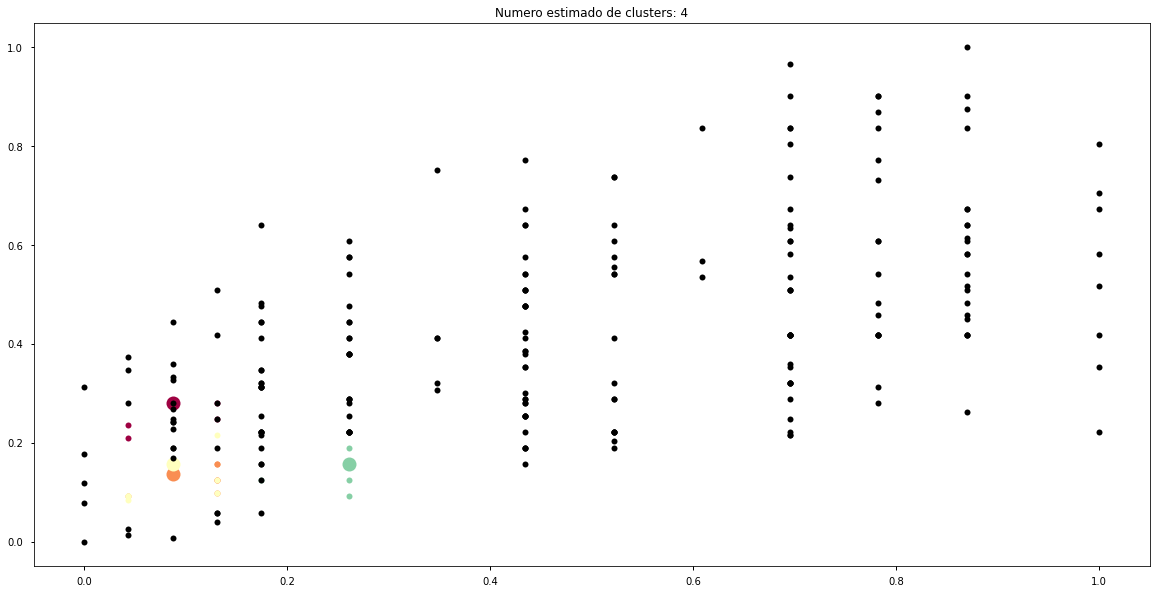

In [ ]:
db = DBSCAN(eps=0.12, min_samples=7).fit(dados) 
core_samples_mask = np.zeros_like(db.labels_, dtype=bool)
core_samples_mask[db.core_sample_indices_] = True
labels = db.labels_

n_clusters_ = len(set(labels)) - (1 if -1 in labels else 0)

plt.figure(figsize=(20,10))
unique_labels = set(labels)
colors = [plt.cm.Spectral(each)
          for each in np.linspace(0, 1, len(unique_labels))]
for k, col in zip(unique_labels, colors):
    if k == -1:        
        col = [0, 0, 0, 1] #Para os pontos de ruido

    class_member_mask = (labels == k)

    xy = dados[class_member_mask & core_samples_mask] #plota os core
    plt.plot(xy[:, 0], xy[:, 1], 'o', markerfacecolor=tuple(col),
             markeredgecolor='k', markersize=14)

    #outliers
    xy = dados[class_member_mask & ~core_samples_mask] #plota os outliers
    plt.plot(xy[:, 0], xy[:, 1], 'o', markerfacecolor=tuple(col),
             markeredgecolor='k', markersize=6)


plt.title('Numero estimado de clusters: %d' % n_clusters_)
plt.show()

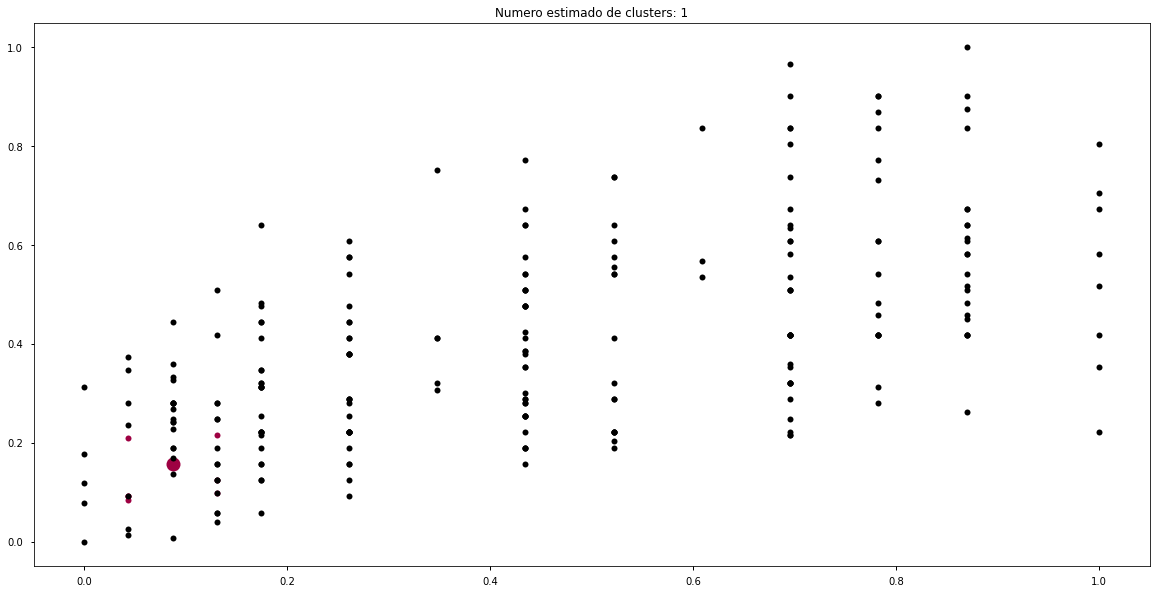

In [ ]:
db = DBSCAN(eps=0.12, min_samples=8).fit(dados) 
core_samples_mask = np.zeros_like(db.labels_, dtype=bool)
core_samples_mask[db.core_sample_indices_] = True
labels = db.labels_

n_clusters_ = len(set(labels)) - (1 if -1 in labels else 0)

plt.figure(figsize=(20,10))
unique_labels = set(labels)
colors = [plt.cm.Spectral(each)
          for each in np.linspace(0, 1, len(unique_labels))]
for k, col in zip(unique_labels, colors):
    if k == -1:        
        col = [0, 0, 0, 1] #Para os pontos de ruido

    class_member_mask = (labels == k)

    xy = dados[class_member_mask & core_samples_mask] #plota os core
    plt.plot(xy[:, 0], xy[:, 1], 'o', markerfacecolor=tuple(col),
             markeredgecolor='k', markersize=14)

    #outliers
    xy = dados[class_member_mask & ~core_samples_mask] #plota os outliers
    plt.plot(xy[:, 0], xy[:, 1], 'o', markerfacecolor=tuple(col),
             markeredgecolor='k', markersize=6)


plt.title('Numero estimado de clusters: %d' % n_clusters_)
plt.show()

##Transformaçao para gerar componente melhor

####PCA
Principal Component Analysis
 
Iremos utilizar o procedimento PCA, ele é um procedimento matemático que utiliza uma transformação ortogonal para converter um conjunto de observações de variáveis correlacionadas num conjunto de valores de variáveis linearmente não correlacionadas chamadas de componentes principais. Possibilitando a redução de dimensionalidade linear usando Decomposição de Valor Singular dos dados para projetá-los para um espaço dimensional inferior. 
 
Tal procedimento pode melhorar o desempenho do algoritmo tendo em vista que com a diminuição da dimensionalidade serão analizados menos componentes e consequentemente diminuindo a complexidade.


In [ ]:
pca = PCA(n_components=2)
principalComponents = pca.fit_transform(dados)

A diferença entre os códigos é somente essas duas linhas e a analise ao invés de ser em cima dos dados sera em _principalComponents_.


###Situação inicial

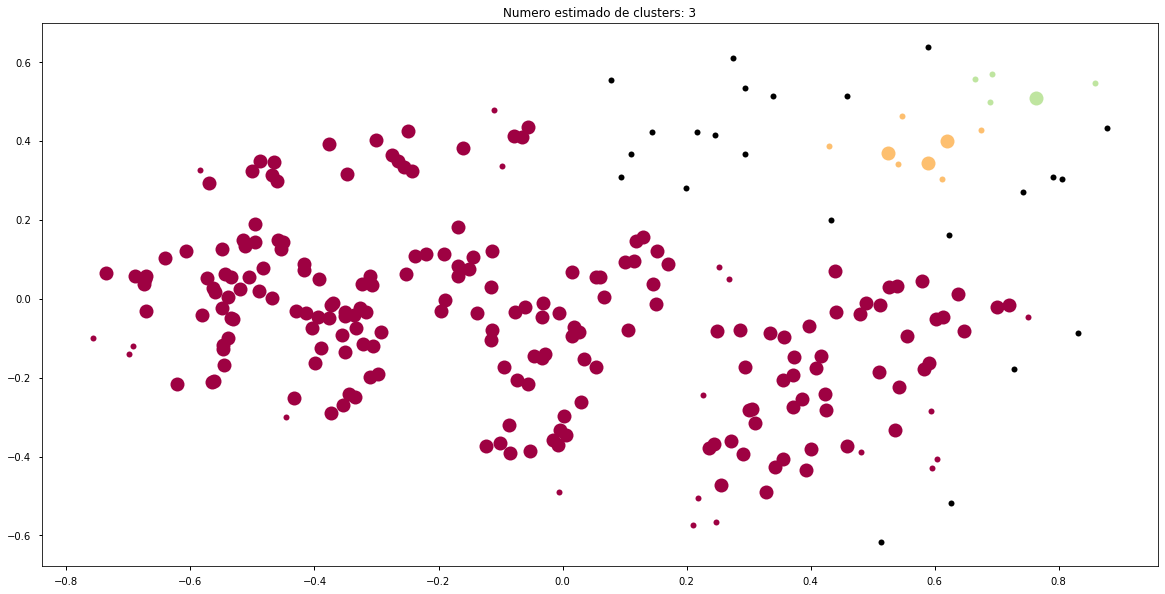

In [ ]:
db = DBSCAN(eps=0.12, min_samples=6).fit(principalComponents)
core_samples_mask = np.zeros_like(db.labels_, dtype=bool)
core_samples_mask[db.core_sample_indices_] = True
labels = db.labels_

n_clusters_ = len(set(labels)) - (1 if -1 in labels else 0)

plt.figure(figsize=(20,10))
unique_labels = set(labels)
colors = [plt.cm.Spectral(each)
          for each in np.linspace(0, 1, len(unique_labels))]
for k, col in zip(unique_labels, colors):
    if k == -1:        
        col = [0, 0, 0, 1] # Para os pontos de ruido

    class_member_mask = (labels == k)

    xy = principalComponents[class_member_mask & core_samples_mask]
    plt.plot(xy[:, 0], xy[:, 1], 'o', markerfacecolor=tuple(col),
             markeredgecolor='k', markersize=14)

    xy = principalComponents[class_member_mask & ~core_samples_mask]
    plt.plot(xy[:, 0], xy[:, 1], 'o', markerfacecolor=tuple(col),
             markeredgecolor='k', markersize=6)


plt.title('Numero estimado de clusters: %d' % n_clusters_)
plt.show()

####Observar a média de tempo
Foi observado que houve uma melhora do tempo, sendo agora que a média está entre 0.0014 e 0.0016.
 
Logo, é mais interessante utilizar o PCA. 


In [ ]:
import time
soma =0

for i in range(0, 1000):
  inicio = time.time()
  db = DBSCAN(eps=0.12, min_samples=6).fit(principalComponents) 
  core_samples_mask = np.zeros_like(db.labels_, dtype=bool)
  core_samples_mask[db.core_sample_indices_] = True
  labels = db.labels_
  fim = time.time()
  soma += (fim - inicio)
print(soma/1000)

0.0015294098854064942


####Mas e se aumentarmos os componentes?

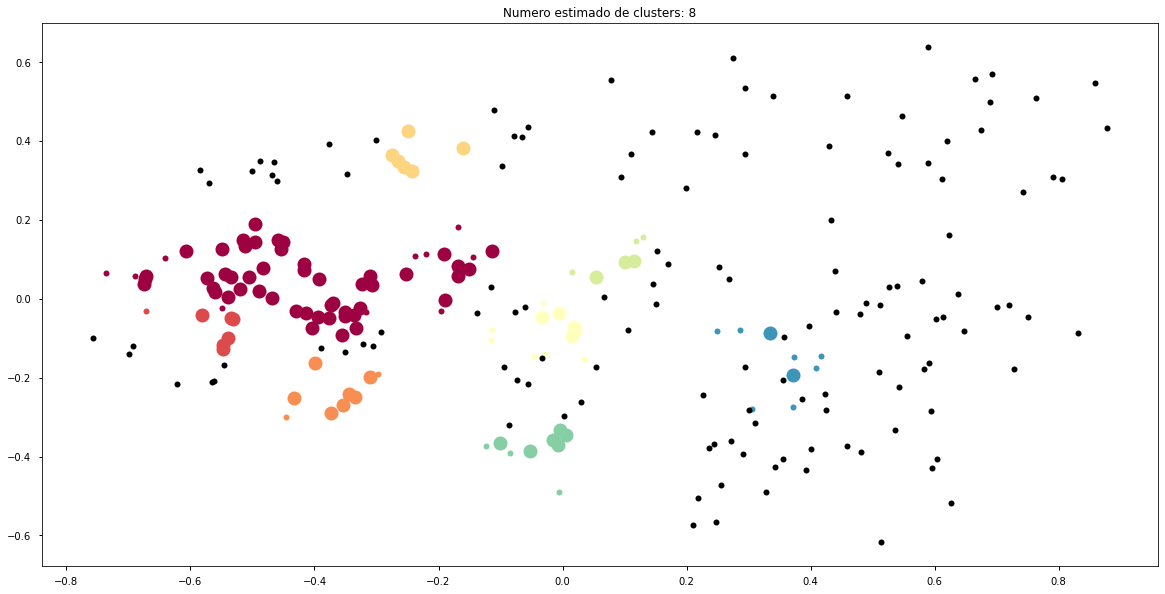

In [ ]:
pca = PCA(n_components=3)
principalComponents = pca.fit_transform(dados)

db = DBSCAN(eps=0.12, min_samples=6).fit(principalComponents)
core_samples_mask = np.zeros_like(db.labels_, dtype=bool)
core_samples_mask[db.core_sample_indices_] = True
labels = db.labels_

# Calcula o numero de clusters
n_clusters_ = len(set(labels)) - (1 if -1 in labels else 0)


# Cria a tabela
plt.figure(figsize=(20,10))
unique_labels = set(labels)
colors = [plt.cm.Spectral(each)
          for each in np.linspace(0, 1, len(unique_labels))]
for k, col in zip(unique_labels, colors):
    if k == -1:        
        col = [0, 0, 0, 1] # Para os pontos de ruido

    class_member_mask = (labels == k)

    xy = principalComponents[class_member_mask & core_samples_mask]
    plt.plot(xy[:, 0], xy[:, 1], 'o', markerfacecolor=tuple(col),
             markeredgecolor='k', markersize=14)

    xy = principalComponents[class_member_mask & ~core_samples_mask]
    plt.plot(xy[:, 0], xy[:, 1], 'o', markerfacecolor=tuple(col),
             markeredgecolor='k', markersize=6)


plt.title('Numero estimado de clusters: %d' % n_clusters_)
plt.show()

Sem resultado satisfatório, retornamos os componentes para 2.


In [ ]:
pca = PCA(n_components=2)
principalComponents = pca.fit_transform(dados)

###Diminuindo eps

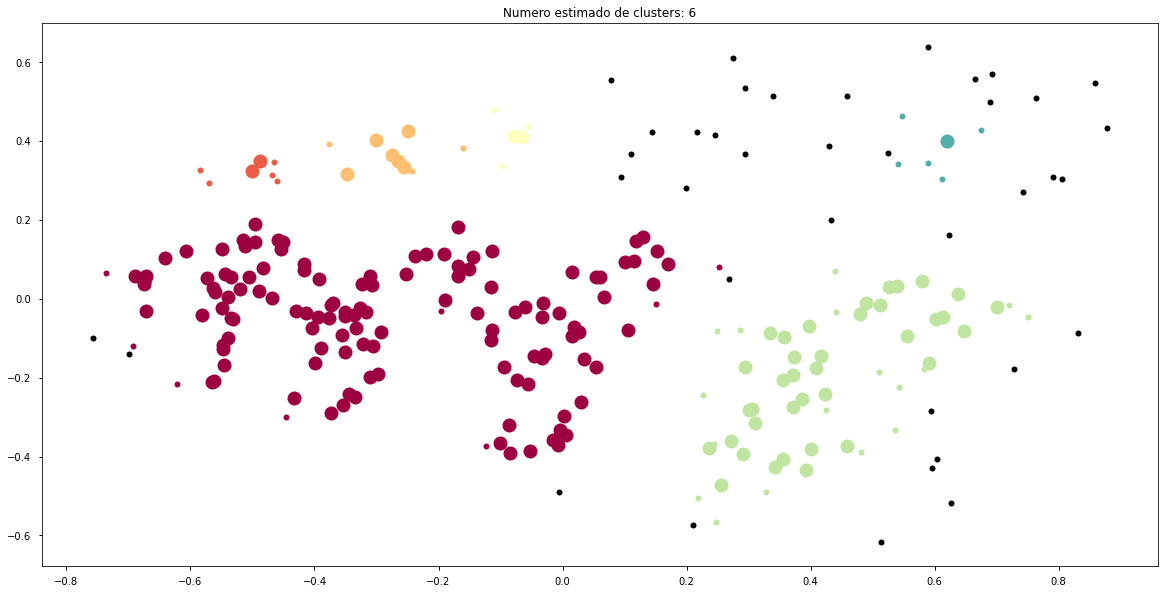

In [ ]:
db = DBSCAN(eps=0.10, min_samples=6).fit(principalComponents)
core_samples_mask = np.zeros_like(db.labels_, dtype=bool)
core_samples_mask[db.core_sample_indices_] = True
labels = db.labels_

n_clusters_ = len(set(labels)) - (1 if -1 in labels else 0)

plt.figure(figsize=(20,10))
unique_labels = set(labels)
colors = [plt.cm.Spectral(each)
          for each in np.linspace(0, 1, len(unique_labels))]
for k, col in zip(unique_labels, colors):
    if k == -1:        
        col = [0, 0, 0, 1] # Para os pontos de ruido

    class_member_mask = (labels == k)

    xy = principalComponents[class_member_mask & core_samples_mask]
    plt.plot(xy[:, 0], xy[:, 1], 'o', markerfacecolor=tuple(col),
             markeredgecolor='k', markersize=14)

    xy = principalComponents[class_member_mask & ~core_samples_mask]
    plt.plot(xy[:, 0], xy[:, 1], 'o', markerfacecolor=tuple(col),
             markeredgecolor='k', markersize=6)


plt.title('Numero estimado de clusters: %d' % n_clusters_)
plt.show()

###Aumentando eps

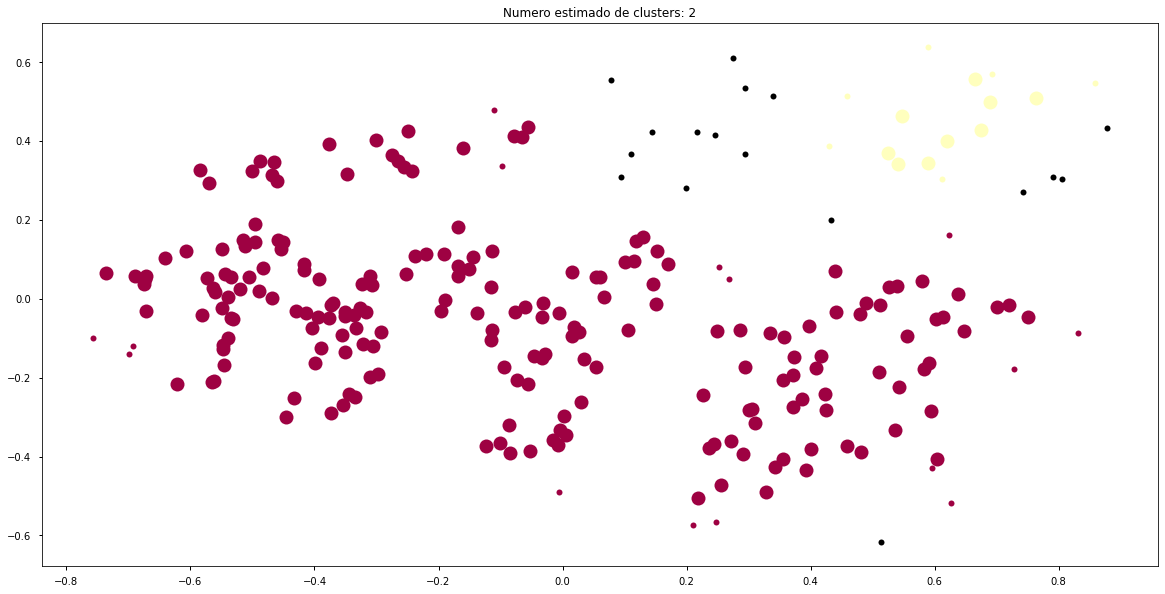

In [ ]:
db = DBSCAN(eps=0.13, min_samples=6).fit(principalComponents)
core_samples_mask = np.zeros_like(db.labels_, dtype=bool)
core_samples_mask[db.core_sample_indices_] = True
labels = db.labels_

n_clusters_ = len(set(labels)) - (1 if -1 in labels else 0)

plt.figure(figsize=(20,10))
unique_labels = set(labels)
colors = [plt.cm.Spectral(each)
          for each in np.linspace(0, 1, len(unique_labels))]
for k, col in zip(unique_labels, colors):
    if k == -1:        
        col = [0, 0, 0, 1] # Para os pontos de ruido

    class_member_mask = (labels == k)

    xy = principalComponents[class_member_mask & core_samples_mask]
    plt.plot(xy[:, 0], xy[:, 1], 'o', markerfacecolor=tuple(col),
             markeredgecolor='k', markersize=14)

    xy = principalComponents[class_member_mask & ~core_samples_mask]
    plt.plot(xy[:, 0], xy[:, 1], 'o', markerfacecolor=tuple(col),
             markeredgecolor='k', markersize=6)


plt.title('Numero estimado de clusters: %d' % n_clusters_)
plt.show()

###Diminuindo min_samples

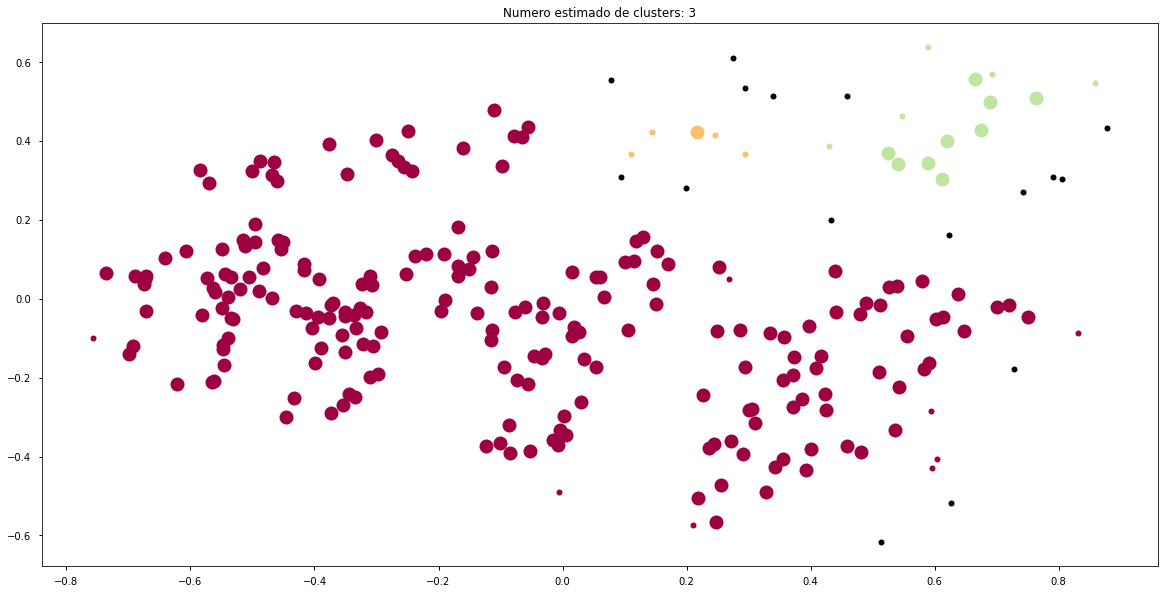

In [ ]:
db = DBSCAN(eps=0.12, min_samples=5).fit(principalComponents)
core_samples_mask = np.zeros_like(db.labels_, dtype=bool)
core_samples_mask[db.core_sample_indices_] = True
labels = db.labels_

n_clusters_ = len(set(labels)) - (1 if -1 in labels else 0)

plt.figure(figsize=(20,10))
unique_labels = set(labels)
colors = [plt.cm.Spectral(each)
          for each in np.linspace(0, 1, len(unique_labels))]
for k, col in zip(unique_labels, colors):
    if k == -1:        
        col = [0, 0, 0, 1] # Para os pontos de ruido

    class_member_mask = (labels == k)

    xy = principalComponents[class_member_mask & core_samples_mask]
    plt.plot(xy[:, 0], xy[:, 1], 'o', markerfacecolor=tuple(col),
             markeredgecolor='k', markersize=14)

    xy = principalComponents[class_member_mask & ~core_samples_mask]
    plt.plot(xy[:, 0], xy[:, 1], 'o', markerfacecolor=tuple(col),
             markeredgecolor='k', markersize=6)


plt.title('Numero estimado de clusters: %d' % n_clusters_)
plt.show()

###Aumentando min_samples

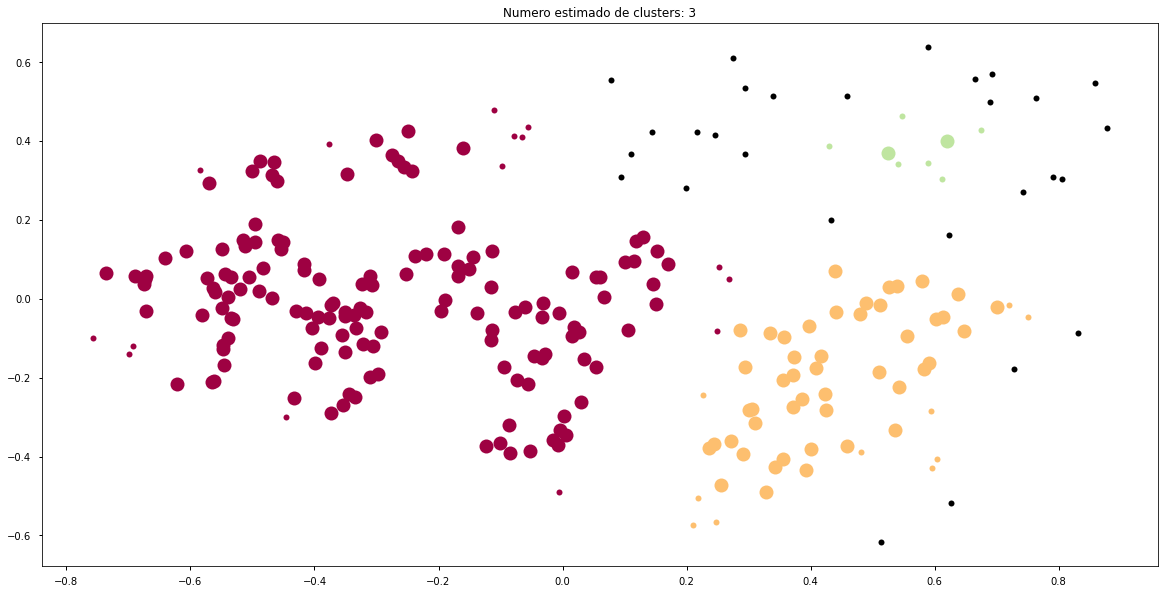

In [ ]:
db = DBSCAN(eps=0.12, min_samples=7).fit(principalComponents)
core_samples_mask = np.zeros_like(db.labels_, dtype=bool)
core_samples_mask[db.core_sample_indices_] = True
labels = db.labels_

n_clusters_ = len(set(labels)) - (1 if -1 in labels else 0)

plt.figure(figsize=(20,10))
unique_labels = set(labels)
colors = [plt.cm.Spectral(each)
          for each in np.linspace(0, 1, len(unique_labels))]
for k, col in zip(unique_labels, colors):
    if k == -1:        
        col = [0, 0, 0, 1] # Para os pontos de ruido

    class_member_mask = (labels == k)

    xy = principalComponents[class_member_mask & core_samples_mask]
    plt.plot(xy[:, 0], xy[:, 1], 'o', markerfacecolor=tuple(col),
             markeredgecolor='k', markersize=14)

    xy = principalComponents[class_member_mask & ~core_samples_mask]
    plt.plot(xy[:, 0], xy[:, 1], 'o', markerfacecolor=tuple(col),
             markeredgecolor='k', markersize=6)


plt.title('Numero estimado de clusters: %d' % n_clusters_)
plt.show()

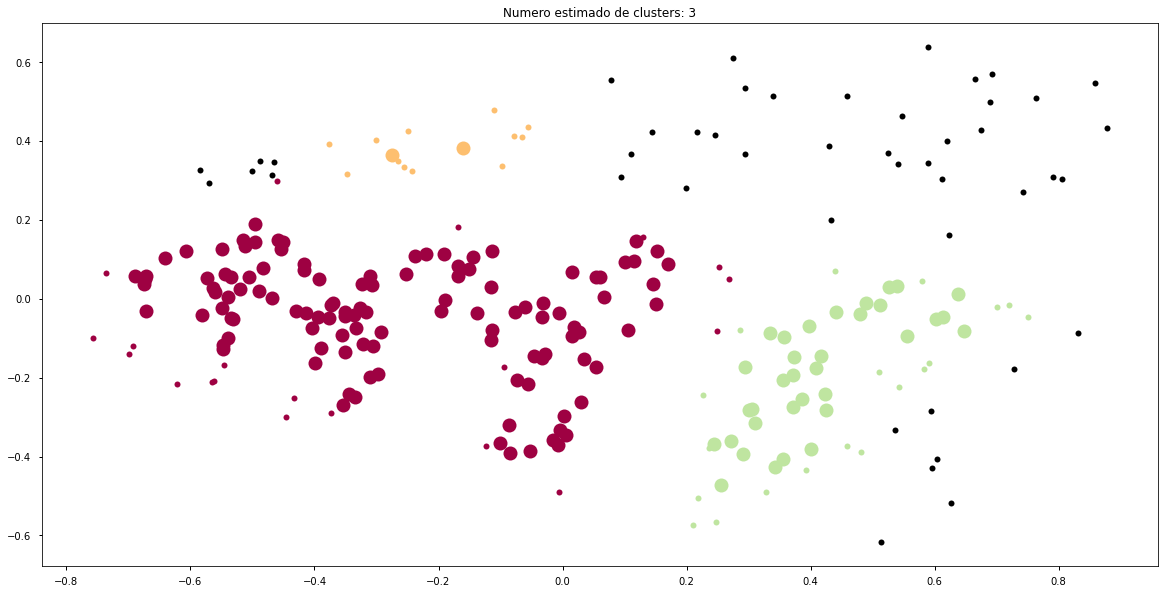

In [ ]:
db = DBSCAN(eps=0.12, min_samples=9).fit(principalComponents)
core_samples_mask = np.zeros_like(db.labels_, dtype=bool)
core_samples_mask[db.core_sample_indices_] = True
labels = db.labels_

n_clusters_ = len(set(labels)) - (1 if -1 in labels else 0)

plt.figure(figsize=(20,10))
unique_labels = set(labels)
colors = [plt.cm.Spectral(each)
          for each in np.linspace(0, 1, len(unique_labels))]
for k, col in zip(unique_labels, colors):
    if k == -1:        
        col = [0, 0, 0, 1] # Para os pontos de ruido

    class_member_mask = (labels == k)

    xy = principalComponents[class_member_mask & core_samples_mask]
    plt.plot(xy[:, 0], xy[:, 1], 'o', markerfacecolor=tuple(col),
             markeredgecolor='k', markersize=14)

    xy = principalComponents[class_member_mask & ~core_samples_mask]
    plt.plot(xy[:, 0], xy[:, 1], 'o', markerfacecolor=tuple(col),
             markeredgecolor='k', markersize=6)


plt.title('Numero estimado de clusters: %d' % n_clusters_)
plt.show()

## Analise final
Para esse algoritmo encontramos os melhores hiperparâmetros sendo _eps=0.1_ e _min_samples=6_ ***_,_*** _eps=0.09_ e _min_samples=4_ ***e*** _eps=0.11_ e _min_samples=5_, todos utilizando o PCA com 2 componentes. Isso corresponde para comparar com os algoritmos anteriores que também obtiveram 6 clusters.

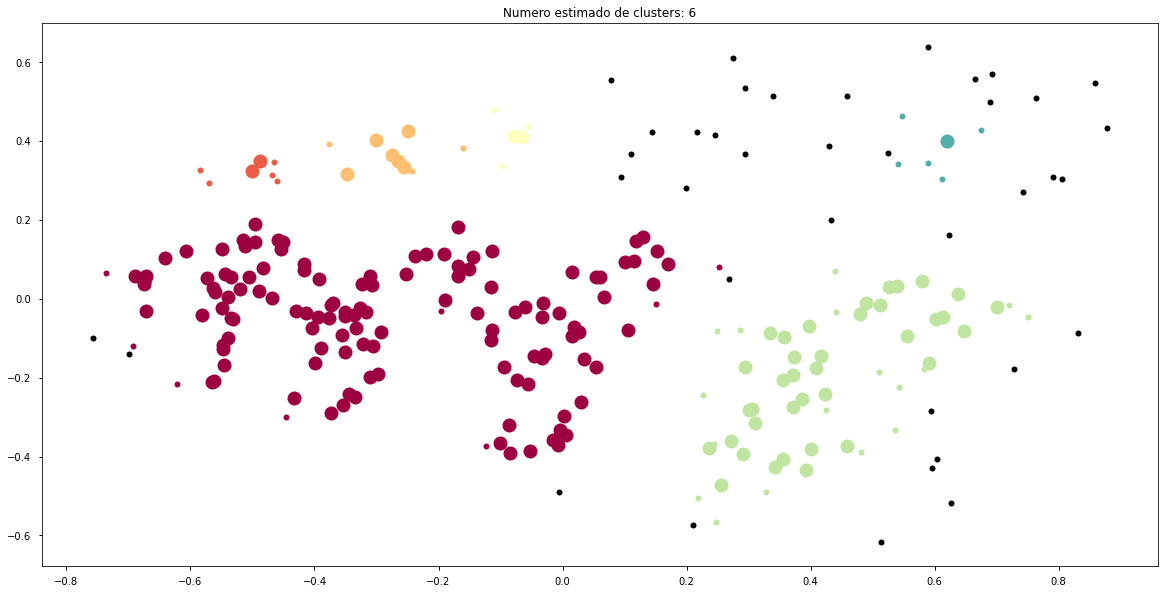

In [ ]:
db = DBSCAN(eps=0.1, min_samples=6).fit(principalComponents)
core_samples_mask = np.zeros_like(db.labels_, dtype=bool)
core_samples_mask[db.core_sample_indices_] = True
labels = db.labels_

n_clusters_ = len(set(labels)) - (1 if -1 in labels else 0)

plt.figure(figsize=(20,10))
unique_labels = set(labels)
colors = [plt.cm.Spectral(each)
          for each in np.linspace(0, 1, len(unique_labels))]
for k, col in zip(unique_labels, colors):
    if k == -1:        
        col = [0, 0, 0, 1] # Para os pontos de ruido

    class_member_mask = (labels == k)

    xy = principalComponents[class_member_mask & core_samples_mask]
    plt.plot(xy[:, 0], xy[:, 1], 'o', markerfacecolor=tuple(col),
             markeredgecolor='k', markersize=14)

    xy = principalComponents[class_member_mask & ~core_samples_mask]
    plt.plot(xy[:, 0], xy[:, 1], 'o', markerfacecolor=tuple(col),
             markeredgecolor='k', markersize=6)

plt.title('Numero estimado de clusters: %d' % n_clusters_)
plt.show()

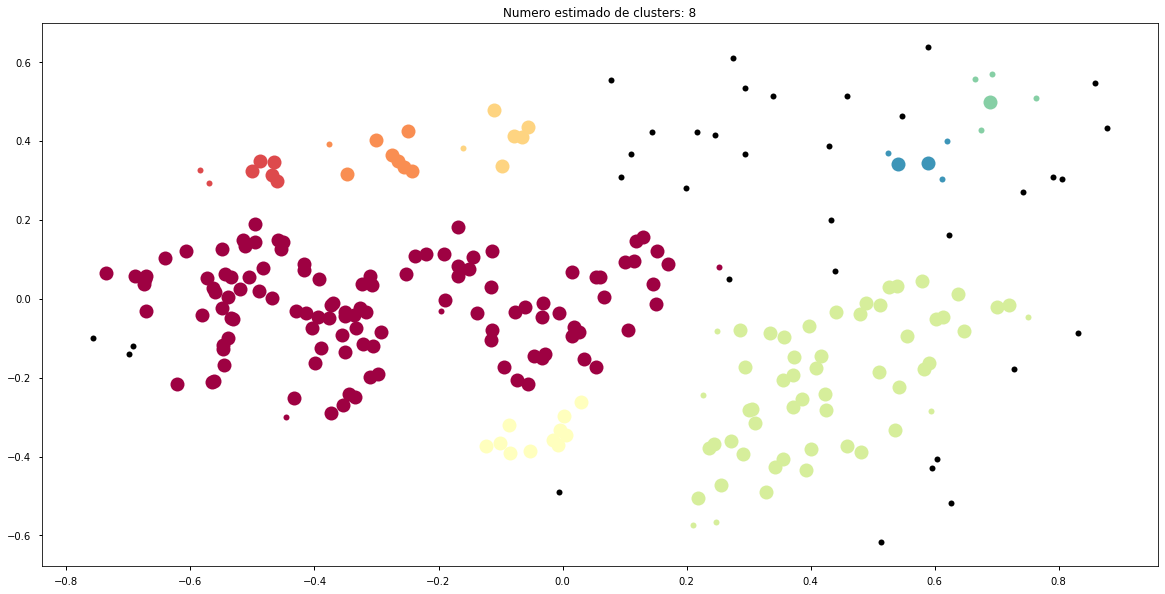

In [ ]:
db = DBSCAN(eps=0.09, min_samples=4).fit(principalComponents)
core_samples_mask = np.zeros_like(db.labels_, dtype=bool)
core_samples_mask[db.core_sample_indices_] = True
labels = db.labels_

n_clusters_ = len(set(labels)) - (1 if -1 in labels else 0)

plt.figure(figsize=(20,10))
unique_labels = set(labels)
colors = [plt.cm.Spectral(each)
          for each in np.linspace(0, 1, len(unique_labels))]
for k, col in zip(unique_labels, colors):
    if k == -1:        
        col = [0, 0, 0, 1] # Para os pontos de ruido

    class_member_mask = (labels == k)

    xy = principalComponents[class_member_mask & core_samples_mask]
    plt.plot(xy[:, 0], xy[:, 1], 'o', markerfacecolor=tuple(col),
             markeredgecolor='k', markersize=14)

    xy = principalComponents[class_member_mask & ~core_samples_mask]
    plt.plot(xy[:, 0], xy[:, 1], 'o', markerfacecolor=tuple(col),
             markeredgecolor='k', markersize=6)

plt.title('Numero estimado de clusters: %d' % n_clusters_)
plt.show()

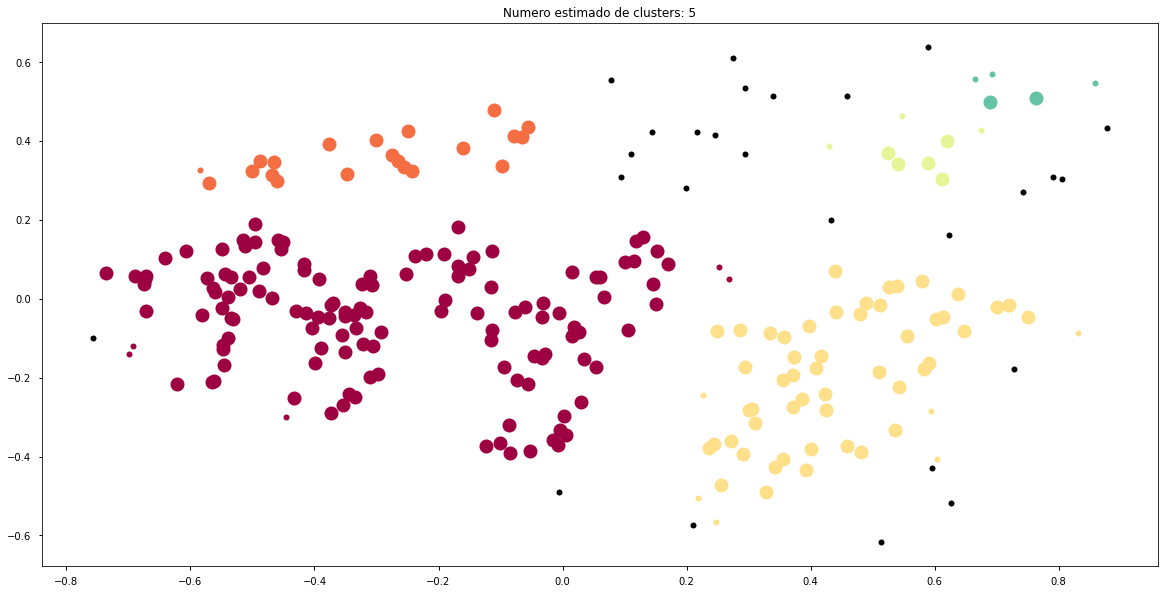

In [ ]:
db = DBSCAN(eps=0.11, min_samples=5).fit(principalComponents)
core_samples_mask = np.zeros_like(db.labels_, dtype=bool)
core_samples_mask[db.core_sample_indices_] = True
labels = db.labels_

n_clusters_ = len(set(labels)) - (1 if -1 in labels else 0)

plt.figure(figsize=(20,10))
unique_labels = set(labels)
colors = [plt.cm.Spectral(each)
          for each in np.linspace(0, 1, len(unique_labels))]
for k, col in zip(unique_labels, colors):
    if k == -1:        
        col = [0, 0, 0, 1] # Para os pontos de ruido

    class_member_mask = (labels == k)

    xy = principalComponents[class_member_mask & core_samples_mask]
    plt.plot(xy[:, 0], xy[:, 1], 'o', markerfacecolor=tuple(col),
             markeredgecolor='k', markersize=14)

    xy = principalComponents[class_member_mask & ~core_samples_mask]
    plt.plot(xy[:, 0], xy[:, 1], 'o', markerfacecolor=tuple(col),
             markeredgecolor='k', markersize=6)

plt.title('Numero estimado de clusters: %d' % n_clusters_)
plt.show()

# Conclusões
K-Means obteve ótimos resultados em comparação ao outos algoritmos analisados, para ele o melhor número de clusters encontrado foi de 5 que era um k com ótimo coeficiente de silhueta no gráfico tanto que seu clusters ficaram um numero similar de objetos.
 
O algoritmo de agrupamento hierárquico conseguiu agrupar os dados de forma eficiente com as métricas Ward e Complete. Mas, para um número grande de clusters, a distância entre os exemplos era menor, o que tornou os resultados menos precisos em relação ao agrupamento K-Means.
 
O pior para esse caso que é disperso é o dbscan, como ele não classifica muito bem dados dispersos logo não se saiu muito bem e obteve um número considerável de ruídos, alem de que seus hiperparâmetros serem muito sensíveis assim o fazendo mais dificil de manusear, talvez os resultados fossem melhores se houvessem um maior de dados que o deixaria mais denso e consequentemente mais preciso.
 
Portanto, observando os três algoritmos e seus respectivos resultados concluímos que para a analise desse conjunto de dados o melhor seria o K-Means.